In [9]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

from transformers import AutoModel

model = AutoModel.from_pretrained(checkpoint)

In [ ]:
from pathlib import Path
import dill


with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)

In [10]:
from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)
import torch
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)

search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,
    ],
    'linear_layer_quantization': [8, 16, 32],
    'linear_layer_quantization_fractional':  [2, 4, 8],
}


INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


In [4]:
from chop.tools.utils import deepsetattr
from copy import deepcopy
from transformers import AutoConfig, AutoModelForSequenceClassification


In [ ]:
from chop.tools.utils import deepsetattr
from copy import deepcopy
from transformers import AutoConfig, AutoModelForSequenceClassification

def construct_model(trial):
    # Fetch the model
    my_config={}
    trial_model = deepcopy(base_model)
    for param in ['linear_layer_quantization','linear_layer_quantization_fractional']:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        my_config[param]=chosen_idx

    # Quantize layers according to optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            # If the chosen layer is integer, define the low precision config
            if new_layer_cls == LinearInteger:
                kwargs["config"] = {
                    "data_in_width": my_config['linear_layer_quantization'],
                    "data_in_frac_width": my_config['linear_layer_quantization_fractional'],
                    "weight_width": my_config['linear_layer_quantization'],
                    "weight_frac_width": my_config['linear_layer_quantization_fractional'],
                    "bias_width": my_config['linear_layer_quantization'],
                    "bias_frac_width": my_config['linear_layer_quantization_fractional'],
                }
            # elif... (other precisions)

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data

            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)

    return trial_model

In [ ]:
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]


from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=20,
    timeout=60 * 60 * 24,
)

[I 2025-02-06 20:41:23,640] A new study created in memory with name: bert-tiny-nas-study
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearInteger'> which is of type type.
  warnings.warn(message)
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.606000
1000,0.439800
1500,0.371200
2000,0.353200
2500,0.342600
3000,0.361000


[I 2025-02-06 20:43:16,322] Trial 0 finished with value: 0.84784 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.module

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693200
2500,0.693200
3000,0.693200


[I 2025-02-06 20:45:26,600] Trial 1 finished with value: 0.5 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.pooler.dense_type': <class 'cho

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2025-02-06 20:47:26,961] Trial 2 finished with value: 0.5 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, '

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2025-02-06 20:49:13,570] Trial 3 finished with value: 0.5 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'classifier_type': <class 'chop.n

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693200
2500,0.693100
3000,0.693100


[I 2025-02-06 20:50:55,667] Trial 4 finished with value: 0.5 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'classifier_type': <class 'torch.

Step,Training Loss
500,0.697800
1000,0.695900
1500,0.697800
2000,0.696700
2500,0.695400
3000,0.696500


[I 2025-02-06 20:52:51,269] Trial 5 finished with value: 0.5 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.pooler.dense_type': <class 'chop.nn.quantized.modules.linear.Li

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2025-02-06 20:54:41,806] Trial 6 finished with value: 0.5 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'classifier_type'

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2025-02-06 20:56:29,374] Trial 7 finished with value: 0.5 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'classifier_type': <class 'chop.n

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2025-02-06 20:58:13,295] Trial 8 finished with value: 0.5 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, '

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2025-02-06 21:00:03,633] Trial 9 finished with value: 0.5 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.pooler.dense_type': <class 'chop.nn.quantized.modules.linear.Li

In [38]:
task1 = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]

In [39]:
task1

[0.84784,
 0.84784,
 0.84784,
 0.84784,
 0.84784,
 0.84784,
 0.84784,
 0.84784,
 0.84784,
 0.84784]

In [7]:
task1

[0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072]

In [ ]:
task1=[
 0.5,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072]

In [270]:
task1 = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]


In [ ]:
task1_pre

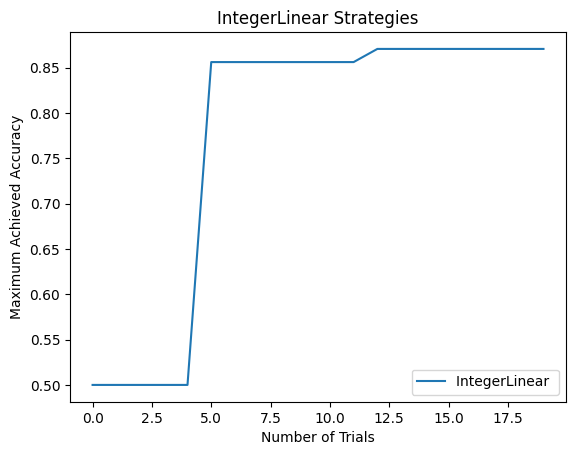

In [8]:
import matplotlib.pyplot as plt

# 横轴：试验次数
x_task1_len= range(len(task1))

# 绘制曲线
plt.plot(x_task1_len, task1, label="IntegerLinear ")

# 图形设置
plt.xlabel("Number of Trials")
plt.ylabel("Maximum Achieved Accuracy")
plt.title("IntegerLinear Strategies")
plt.legend()
plt.show()

In [273]:
from pathlib import Path
import dill

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)
search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,
        LinearMinifloatDenorm,
        LinearMinifloatIEEE,
        LinearLog,
        LinearBlockFP,
        # LinearBlockMinifloat,
        LinearBlockLog,
        LinearBinary,
        LinearBinaryScaling,
        LinearBinaryResidualSign,
    ],
    'linear_layer_quantization': [8, 16, 32],
    'linear_layer_quantization_fractional':  [2, 4, 8],
    'LinearMinifloatDenorm': [8, 16, 32],
    'LinearMinifloatDenorm_ew': [2, 4, 8],
    'LinearMinifloatDenorm_eb': [2, 4, 8],
    'LinearMinifloatIEEE': [8, 16, 32],
    'LinearMinifloatIEEE_ew': [2, 4, 8],
    'LinearMinifloatIEEE_eb': [2, 4, 8],
    'LinearLog': [8, 16, 32],
    'LinearLog_ew': [2, 4, 8],
    'LinearLog_eb': [2, 4, 8],
    'LinearBlockFP': [8, 16, 32],
    'LinearBlockFP_block_size':[[4], [8], [16]] ,
    'LinearBlockMinifloat_ebw': [2, 4, 8],
    'LinearBlockMinifloat_ew': [2, 4, 8],
    'LinearBlockMinifloat_block_size': [[4], [8], [16]],
    'LinearBlockMinifloat_w': [2, 4, 8],
    'LinearBlockLog': [8, 16, 32],
    'LinearBlockLog_ebw': [2, 4, 8],
    'LinearBlockLog_block_size': [[4], [8], [16]] ,
    'LinearBinary_stochastic': [2, 4, 8],
    'LinearBinary_bipolar': [2, 4, 8],
    'LinearBinaryScaling_stochastic': [2, 4, 8],
    'LinearBinaryScaling_bipolar': [2, 4, 8],
    "LinearBinaryScaling_binary_training": [2, 4, 8],
    'LinearBinaryResidualSign_stochastic': [2, 4, 8],
    'LinearBinaryResidualSign_bipolar': [2, 4, 8],
    "LinearBinaryResidualSign_binary_training": [2, 4, 8],
}


In [275]:
def construct_model(trial):
    # Fetch the model
    my_config = {}
    trial_model = deepcopy(base_model)
    
    # Select quantization and fractional width configurations
    for param in ['linear_layer_quantization', 
                  'linear_layer_quantization_fractional',
                  'LinearMinifloatDenorm',
                  'LinearMinifloatDenorm_ew',
                  'LinearMinifloatDenorm_eb',
                  'LinearMinifloatIEEE',
                  'LinearMinifloatIEEE_ew',
                  'LinearMinifloatIEEE_eb',
                    'LinearLog',
                    'LinearLog_ew',
                    'LinearLog_eb',
                    'LinearBlockFP',
                    'LinearBlockFP_block_size',
                    'LinearBlockMinifloat_ebw',
                    'LinearBlockMinifloat_ew',
                    'LinearBlockMinifloat_block_size',
                    'LinearBlockMinifloat_w',
                    'LinearBlockLog',
                    'LinearBlockLog_ebw',
                    'LinearBlockLog_block_size',
                    'LinearBinary_stochastic',
                    'LinearBinary_bipolar',
                    'LinearBinaryScaling_stochastic',
                    'LinearBinaryScaling_bipolar',
                    'LinearBinaryScaling_binary_training',
                    'LinearBinaryResidualSign_stochastic',
                    'LinearBinaryResidualSign_bipolar',
                    'LinearBinaryResidualSign_binary_training'
                  ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        my_config[param] = search_space[param][chosen_idx]

    # Quantize layers according to Optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            try:
                # Configure parameters for specific layer types
                if new_layer_cls == LinearInteger:
                    kwargs["config"] = {
                        "data_in_width": my_config['linear_layer_quantization'],
                        "data_in_frac_width": my_config['linear_layer_quantization_fractional'],
                        "weight_width": my_config['linear_layer_quantization'],
                        "weight_frac_width": my_config['linear_layer_quantization_fractional'],
                        "bias_width": my_config['linear_layer_quantization'],
                        "bias_frac_width": my_config['linear_layer_quantization_fractional'],
                    }
                elif new_layer_cls == LinearMinifloatDenorm:
                    kwargs["config"] = {
                        "data_in_width": my_config['LinearMinifloatDenorm'],
                        "data_in_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                        "data_in_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                        "weight_width": my_config['LinearMinifloatDenorm'],
                        "weight_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                        "weight_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                        "bias_width": my_config['LinearMinifloatDenorm'],
                        "bias_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                        "bias_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                    }
                elif new_layer_cls == LinearMinifloatIEEE:
                    kwargs["config"] = {
                        "data_in_width": my_config['LinearMinifloatIEEE'],
                        "data_in_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                        "data_in_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                        "weight_width": my_config['LinearMinifloatIEEE'],
                        "weight_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                        "weight_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                        "bias_width": my_config['LinearMinifloatIEEE'],
                        "bias_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                        "bias_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                    }
                elif new_layer_cls == LinearLog:
                    kwargs["config"] = {
                        "data_in_width": my_config['LinearLog'],
                        "data_in_exponent_width": my_config['LinearLog_ew'],
                        "data_in_exponent_bias": my_config['LinearLog_eb'],
                        "weight_width": my_config['LinearLog'],
                        "weight_exponent_width": my_config['LinearLog_ew'],
                        "weight_exponent_bias": my_config['LinearLog_eb'],
                        "bias_width": my_config['LinearLog'],
                        "bias_exponent_width": my_config['LinearLog_ew'],
                        "bias_exponent_bias": my_config['LinearLog_eb'],
                    }
                elif new_layer_cls == LinearBlockFP:
                    kwargs["config"] = {
                        "weight_width": my_config['LinearBlockFP'],
                        "weight_exponent_width": my_config['LinearBlockFP'],
                        "weight_block_size": my_config['LinearBlockFP_block_size'],
                        "weight_exponent_bias": my_config['LinearBlockFP'],
                        "data_in_width": my_config['LinearBlockFP'],
                        "data_in_exponent_width": my_config['LinearBlockFP'],
                        "data_in_block_size": my_config['LinearBlockFP_block_size'],
                        "data_in_exponent_bias": my_config['LinearBlockFP'],
                        "bias_width": my_config['LinearBlockFP'],
                        "bias_exponent_width": my_config['LinearBlockFP'],
                        "bias_block_size": my_config['LinearBlockFP_block_size'],
                        "bias_exponent_bias": my_config['LinearBlockFP'],
                    }
                # elif new_layer_cls == LinearBlockMinifloat:
                #     kwargs["config"] = {
                #         "weight_exponent_bias_width" : my_config['LinearBlockMinifloat_ebw'],
                #         "weight_exponent_width": my_config['LinearBlockMinifloat_ew'],
                #         "weight_block_size": my_config['LinearBlockMinifloat_block_size'],
                #         "weight_width": my_config['LinearBlockMinifloat_w'],
                #         "data_in_width":my_config["LinearBlockMinifloat_w"],
                #         "data_in_exponent_bias_width":my_config["LinearBlockMinifloat_ew"],
                #         "data_in_exponent_width":my_config["LinearBlockMinifloat_ebw"],
                #         "data_in_block_size":my_config["LinearBlockMinifloat_block_size"],
                #         "bias_width":my_config["LinearBlockMinifloat_w"],
                #         "bias_exponent_width":my_config["LinearBlockMinifloat_ew"],
                #         "bias_exponent_bias_width":my_config["LinearBlockMinifloat_ebw"],
                #         "bias_block_size":my_config["LinearBlockMinifloat_block_size"],
                #     }
                elif new_layer_cls == LinearBlockLog:
                    kwargs["config"] = {
                        "data_in_width": my_config['LinearBlockLog'],
                        "data_in_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                        "data_in_block_size": my_config['LinearBlockLog_block_size'],
                        "weight_width": my_config['LinearBlockLog'],
                        "weight_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                        "weight_block_size": my_config['LinearBlockLog_block_size'],
                        "bias_width": my_config['LinearBlockLog'],
                        "bias_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                        "bias_block_size": my_config['LinearBlockLog_block_size'],
                    }

                elif new_layer_cls == LinearBinary:
                    kwargs["config"] = {
                        'weight_stochastic':my_config['LinearBinary_stochastic'],
                        'weight_bipolar':my_config['LinearBinary_bipolar'],
                    }

                    
                elif new_layer_cls == LinearBinaryScaling:
                    kwargs["config"] = {
                        'weight_stochastic':my_config['LinearBinaryScaling_stochastic'],
                        'weight_bipolar':my_config['LinearBinaryScaling_bipolar'],
                        "data_in_stochastic": my_config['LinearBinaryScaling_stochastic'],
                        "data_in_bipolar": my_config['LinearBinaryScaling_bipolar'],
                        "bias_stochastic": my_config['LinearBinaryScaling_stochastic'],
                        "bias_bipolar": my_config['LinearBinaryScaling_bipolar'],
                        "binary_training": my_config['LinearBinaryScaling_binary_training'],
                    }
                elif new_layer_cls == LinearBinaryResidualSign:
                    kwargs["config"] = {
                        'weight_stochastic':my_config['LinearBinaryResidualSign_stochastic'],
                        'weight_bipolar':my_config['LinearBinaryResidualSign_bipolar'],
                        "data_in_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                        "data_in_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                        "bias_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                        "bias_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                        "binary_training": my_config['LinearBinaryResidualSign_binary_training'],
                    }
                # Create the new layer (copy the weights if applicable)
                new_layer = new_layer_cls(**kwargs)
                new_layer.weight.data = layer.weight.data.clone()

                # Replace the layer in the model
                deepsetattr(trial_model, name, new_layer)
            except TypeError as e:
                print(f"Error creating layer {name} with class {new_layer_cls}: {e}")
                raise

    return trial_model


In [ ]:
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]


from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=10,
    timeout=60 * 60 * 24,
)

In [277]:
task2 = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]

In [ ]:
task2

In [ ]:
import matplotlib.pyplot as plt

# 横轴：试验次数
x_task2_len= range(len(task2))

# 绘制曲线
plt.plot(x_task2_len, task2, label=" all supported precisions for the Linear layer ")

# 图形设置
plt.xlabel("Number of Trials")
plt.ylabel("Maximum Achieved Accuracy")
plt.title(" all supported precisions for the Linear layer Strategies")
plt.legend()
plt.show()

## -------------------------------------

In [12]:
dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


In [ ]:

from pathlib import Path
import dill
import torch

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)
search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        # LinearInteger,
        LinearMinifloatDenorm,
        # LinearMinifloatIEEE,
        # LinearLog,
        # LinearBlockFP,
        # # LinearBlockMinifloat,
        # LinearBlockLog,
        # LinearBinary,
        # LinearBinaryScaling,
        # LinearBinaryResidualSign,
    ],
    'linear_layer_quantization': [8, 16, 32],
    'linear_layer_quantization_fractional':  [2, 4, 8],
    'LinearMinifloatDenorm': [8, 16, 32],
    'LinearMinifloatDenorm_ew': [2, 4, 8],
    'LinearMinifloatDenorm_eb': [2, 4, 8],
    'LinearMinifloatIEEE': [8, 16, 32],
    'LinearMinifloatIEEE_ew': [2, 4, 8],
    'LinearMinifloatIEEE_eb': [2, 4, 8],
    'LinearLog': [8, 16, 32],
    'LinearLog_ew': [2, 4, 8],
    'LinearLog_eb': [2, 4, 8],
    'LinearBlockFP': [8, 16, 32],
    'LinearBlockFP_block_size':[[4], [8], [16]] ,
    'LinearBlockMinifloat_ebw': [2, 4, 8],
    'LinearBlockMinifloat_ew': [2, 4, 8],
    'LinearBlockMinifloat_block_size': [[4], [8], [16]],
    'LinearBlockMinifloat_w': [2, 4, 8],
    'LinearBlockLog': [8, 16, 32],
    'LinearBlockLog_ebw': [2, 4, 8],
    'LinearBlockLog_block_size': [[4], [8], [16]] ,
    'LinearBinary_stochastic': [2, 4, 8],
    'LinearBinary_bipolar': [2, 4, 8],
    'LinearBinaryScaling_stochastic': [2, 4, 8],
    'LinearBinaryScaling_bipolar': [2, 4, 8],
    "LinearBinaryScaling_binary_training": [2, 4, 8],
    'LinearBinaryResidualSign_stochastic': [2, 4, 8],
    'LinearBinaryResidualSign_bipolar': [2, 4, 8],
    "LinearBinaryResidualSign_binary_training": [2, 4, 8],
}

def construct_model(trial):
    # Fetch the model
    my_config = {}
    trial_model = deepcopy(base_model)
    
    # Select quantization and fractional width configurations
    for param in ['linear_layer_quantization', 
                  'linear_layer_quantization_fractional',
                  'LinearMinifloatDenorm',
                  'LinearMinifloatDenorm_ew',
                  'LinearMinifloatDenorm_eb',
                  'LinearMinifloatIEEE',
                  'LinearMinifloatIEEE_ew',
                  'LinearMinifloatIEEE_eb',
                    'LinearLog',
                    'LinearLog_ew',
                    'LinearLog_eb',
                    'LinearBlockFP',
                    'LinearBlockFP_block_size',
                    'LinearBlockMinifloat_ebw',
                    'LinearBlockMinifloat_ew',
                    'LinearBlockMinifloat_block_size',
                    'LinearBlockMinifloat_w',
                    'LinearBlockLog',
                    'LinearBlockLog_ebw',
                    'LinearBlockLog_block_size',
                    'LinearBinary_stochastic',
                    'LinearBinary_bipolar',
                    'LinearBinaryScaling_stochastic',
                    'LinearBinaryScaling_bipolar',
                    'LinearBinaryScaling_binary_training',
                    'LinearBinaryResidualSign_stochastic',
                    'LinearBinaryResidualSign_bipolar',
                    'LinearBinaryResidualSign_binary_training'
                  ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        my_config[param] = search_space[param][chosen_idx]

    # Quantize layers according to Optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            try:
                # Configure parameters for specific layer types
                # if new_layer_cls == LinearInteger:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['linear_layer_quantization'],
                #         "data_in_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "weight_width": my_config['linear_layer_quantization'],
                #         "weight_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "bias_width": my_config['linear_layer_quantization'],
                #         "bias_frac_width": my_config['linear_layer_quantization_fractional'],
                #     }
                if new_layer_cls == LinearMinifloatDenorm:
                    kwargs["config"] = {
                        "data_in_width": my_config['LinearMinifloatDenorm'],
                        "data_in_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                        "data_in_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                        "weight_width": my_config['LinearMinifloatDenorm'],
                        "weight_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                        "weight_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                        "bias_width": my_config['LinearMinifloatDenorm'],
                        "bias_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                        "bias_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                    }
                # elif new_layer_cls == LinearMinifloatIEEE:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatIEEE'],
                #         "data_in_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "weight_width": my_config['LinearMinifloatIEEE'],
                #         "weight_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "bias_width": my_config['LinearMinifloatIEEE'],
                #         "bias_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #     }
                # elif new_layer_cls == LinearLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearLog'],
                #         "data_in_exponent_width": my_config['LinearLog_ew'],
                #         "data_in_exponent_bias": my_config['LinearLog_eb'],
                #         "weight_width": my_config['LinearLog'],
                #         "weight_exponent_width": my_config['LinearLog_ew'],
                #         "weight_exponent_bias": my_config['LinearLog_eb'],
                #         "bias_width": my_config['LinearLog'],
                #         "bias_exponent_width": my_config['LinearLog_ew'],
                #         "bias_exponent_bias": my_config['LinearLog_eb'],
                #     }
                # elif new_layer_cls == LinearBlockFP:
                #     kwargs["config"] = {
                #         "weight_width": my_config['LinearBlockFP'],
                #         "weight_exponent_width": my_config['LinearBlockFP'],
                #         "weight_block_size": my_config['LinearBlockFP_block_size'],
                #         "weight_exponent_bias": my_config['LinearBlockFP'],
                #         "data_in_width": my_config['LinearBlockFP'],
                #         "data_in_exponent_width": my_config['LinearBlockFP'],
                #         "data_in_block_size": my_config['LinearBlockFP_block_size'],
                #         "data_in_exponent_bias": my_config['LinearBlockFP'],
                #         "bias_width": my_config['LinearBlockFP'],
                #         "bias_exponent_width": my_config['LinearBlockFP'],
                #         "bias_block_size": my_config['LinearBlockFP_block_size'],
                #         "bias_exponent_bias": my_config['LinearBlockFP'],
                #     }
                # # elif new_layer_cls == LinearBlockMinifloat:
                # #     kwargs["config"] = {
                # #         "weight_exponent_bias_width" : my_config['LinearBlockMinifloat_ebw'],
                # #         "weight_exponent_width": my_config['LinearBlockMinifloat_ew'],
                # #         "weight_block_size": my_config['LinearBlockMinifloat_block_size'],
                # #         "weight_width": my_config['LinearBlockMinifloat_w'],
                # #         "data_in_width":my_config["LinearBlockMinifloat_w"],
                # #         "data_in_exponent_bias_width":my_config["LinearBlockMinifloat_ew"],
                # #         "data_in_exponent_width":my_config["LinearBlockMinifloat_ebw"],
                # #         "data_in_block_size":my_config["LinearBlockMinifloat_block_size"],
                # #         "bias_width":my_config["LinearBlockMinifloat_w"],
                # #         "bias_exponent_width":my_config["LinearBlockMinifloat_ew"],
                # #         "bias_exponent_bias_width":my_config["LinearBlockMinifloat_ebw"],
                # #         "bias_block_size":my_config["LinearBlockMinifloat_block_size"],
                # #     }
                # elif new_layer_cls == LinearBlockLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearBlockLog'],
                #         "data_in_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "data_in_block_size": my_config['LinearBlockLog_block_size'],
                #         "weight_width": my_config['LinearBlockLog'],
                #         "weight_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "weight_block_size": my_config['LinearBlockLog_block_size'],
                #         "bias_width": my_config['LinearBlockLog'],
                #         "bias_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "bias_block_size": my_config['LinearBlockLog_block_size'],
                #     }

                # elif new_layer_cls == LinearBinary:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinary_stochastic'],
                #         'weight_bipolar':my_config['LinearBinary_bipolar'],
                #     }

                    
                # elif new_layer_cls == LinearBinaryScaling:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryScaling_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryScaling_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "binary_training": my_config['LinearBinaryScaling_binary_training'],
                #     }
                # elif new_layer_cls == LinearBinaryResidualSign:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryResidualSign_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryResidualSign_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "binary_training": my_config['LinearBinaryResidualSign_binary_training'],
                #     }
                # Create the new layer (copy the weights if applicable)
                new_layer = new_layer_cls(**kwargs)
                new_layer.weight.data = layer.weight.data.clone()

                # Replace the layer in the model
                deepsetattr(trial_model, name, new_layer)
            except TypeError as e:
                print(f"Error creating layer {name} with class {new_layer_cls}: {e}")
                raise

    return trial_model
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]


from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=20,
    timeout=60 * 60 * 24,
)

task3 = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]
task3

[I 2025-02-06 12:05:11,350] A new study created in memory with name: bert-tiny-nas-study


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[2025-02-06 12:05:17,250] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Step,Training Loss
500,0.340800
1000,0.301800
1500,0.331500
2000,0.344600
2500,0.334200
3000,0.366500


[I 2025-02-06 12:09:22,562] Trial 0 finished with value: 0.87256 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 0, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.340700
1000,0.307400
1500,0.336300
2000,0.343300
2500,0.335100
3000,0.359800


[I 2025-02-06 12:13:19,388] Trial 1 finished with value: 0.87268 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 1, 'LinearLog_ew': 0, 'LinearLog_eb': 2, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.663100
1000,0.620900
1500,0.597900
2000,0.580400
2500,0.564000
3000,0.561900


[I 2025-02-06 12:17:43,549] Trial 2 finished with value: 0.84592 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 1, 'LinearLog_ew': 0, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.341400
1000,0.313600
1500,0.345300
2000,0.337400
2500,0.335100
3000,0.359000


[I 2025-02-06 12:21:37,682] Trial 3 finished with value: 0.87264 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.339300
1000,0.306300
1500,0.335700
2000,0.346400
2500,0.336400
3000,0.362500


[I 2025-02-06 12:24:04,789] Trial 4 finished with value: 0.87284 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 1, 'LinearLog_ew': 2, 'LinearLog_eb': 2, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.339400
1000,0.310100
1500,0.343300
2000,0.345500
2500,0.337600
3000,0.363500


[I 2025-02-06 12:27:00,492] Trial 5 finished with value: 0.87284 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.337200
1000,0.306800
1500,0.331000
2000,0.346900
2500,0.334900
3000,0.366000


[I 2025-02-06 12:30:43,815] Trial 6 finished with value: 0.87296 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 2, 'LinearLog_ew': 2, 'LinearLog_eb': 0, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.342900
1000,0.333500
1500,0.358800
2000,0.345600
2500,0.326600
3000,0.369900


[I 2025-02-06 12:32:57,109] Trial 7 finished with value: 0.8698 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 1, 'LinearLog_ew': 2, 'LinearLog_eb': 1, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'cho

Step,Training Loss
500,0.340800
1000,0.307100
1500,0.329200
2000,0.346700
2500,0.333400
3000,0.367700


[I 2025-02-06 12:36:37,513] Trial 8 finished with value: 0.8738 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 1, 'LinearLog_ew': 2, 'LinearLog_eb': 0, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'tor

Step,Training Loss
500,0.341600
1000,0.306600
1500,0.328900
2000,0.338600
2500,0.328700
3000,0.365600


[I 2025-02-06 12:39:20,587] Trial 9 finished with value: 0.87188 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 1, 'LinearLog_ew': 2, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

[0.87256,
 0.87268,
 0.87268,
 0.87268,
 0.87284,
 0.87284,
 0.87296,
 0.87296,
 0.8738,
 0.8738]

In [2]:
task3 =[0.87256,
 0.87268,
 0.87268,
 0.87268,
 0.87284,
 0.87284,
 0.87296,
 0.87296,
 0.8738,
 0.8738]

In [ ]:

from pathlib import Path
import dill

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)
search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        # LinearInteger,
        # LinearMinifloatDenorm,
        LinearMinifloatIEEE,
        # LinearLog,
        # LinearBlockFP,
        # # LinearBlockMinifloat,
        # LinearBlockLog,
        # LinearBinary,
        # LinearBinaryScaling,
        # LinearBinaryResidualSign,
    ],
    'linear_layer_quantization': [8, 16, 32],
    'linear_layer_quantization_fractional':  [2, 4, 8],
    'LinearMinifloatDenorm': [8, 16, 32],
    'LinearMinifloatDenorm_ew': [2, 4, 8],
    'LinearMinifloatDenorm_eb': [2, 4, 8],
    'LinearMinifloatIEEE': [8, 16, 32],
    'LinearMinifloatIEEE_ew': [2, 4, 8],
    'LinearMinifloatIEEE_eb': [2, 4, 8],
    'LinearLog': [8, 16, 32],
    'LinearLog_ew': [2, 4, 8],
    'LinearLog_eb': [2, 4, 8],
    'LinearBlockFP': [8, 16, 32],
    'LinearBlockFP_block_size':[[4], [8], [16]] ,
    'LinearBlockMinifloat_ebw': [2, 4, 8],
    'LinearBlockMinifloat_ew': [2, 4, 8],
    'LinearBlockMinifloat_block_size': [[4], [8], [16]],
    'LinearBlockMinifloat_w': [2, 4, 8],
    'LinearBlockLog': [8, 16, 32],
    'LinearBlockLog_ebw': [2, 4, 8],
    'LinearBlockLog_block_size': [[4], [8], [16]] ,
    'LinearBinary_stochastic': [2, 4, 8],
    'LinearBinary_bipolar': [2, 4, 8],
    'LinearBinaryScaling_stochastic': [2, 4, 8],
    'LinearBinaryScaling_bipolar': [2, 4, 8],
    "LinearBinaryScaling_binary_training": [2, 4, 8],
    'LinearBinaryResidualSign_stochastic': [2, 4, 8],
    'LinearBinaryResidualSign_bipolar': [2, 4, 8],
    "LinearBinaryResidualSign_binary_training": [2, 4, 8],
}

def construct_model(trial):
    # Fetch the model
    my_config = {}
    trial_model = deepcopy(base_model)
    
    # Select quantization and fractional width configurations
    for param in ['linear_layer_quantization', 
                  'linear_layer_quantization_fractional',
                  'LinearMinifloatDenorm',
                  'LinearMinifloatDenorm_ew',
                  'LinearMinifloatDenorm_eb',
                  'LinearMinifloatIEEE',
                  'LinearMinifloatIEEE_ew',
                  'LinearMinifloatIEEE_eb',
                    'LinearLog',
                    'LinearLog_ew',
                    'LinearLog_eb',
                    'LinearBlockFP',
                    'LinearBlockFP_block_size',
                    'LinearBlockMinifloat_ebw',
                    'LinearBlockMinifloat_ew',
                    'LinearBlockMinifloat_block_size',
                    'LinearBlockMinifloat_w',
                    'LinearBlockLog',
                    'LinearBlockLog_ebw',
                    'LinearBlockLog_block_size',
                    'LinearBinary_stochastic',
                    'LinearBinary_bipolar',
                    'LinearBinaryScaling_stochastic',
                    'LinearBinaryScaling_bipolar',
                    'LinearBinaryScaling_binary_training',
                    'LinearBinaryResidualSign_stochastic',
                    'LinearBinaryResidualSign_bipolar',
                    'LinearBinaryResidualSign_binary_training'
                  ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        my_config[param] = search_space[param][chosen_idx]

    # Quantize layers according to Optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            try:
                # Configure parameters for specific layer types
                # if new_layer_cls == LinearInteger:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['linear_layer_quantization'],
                #         "data_in_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "weight_width": my_config['linear_layer_quantization'],
                #         "weight_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "bias_width": my_config['linear_layer_quantization'],
                #         "bias_frac_width": my_config['linear_layer_quantization_fractional'],
                #     }
                # elif new_layer_cls == LinearMinifloatDenorm:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatDenorm'],
                #         "data_in_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "weight_width": my_config['LinearMinifloatDenorm'],
                #         "weight_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "bias_width": my_config['LinearMinifloatDenorm'],
                #         "bias_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #     }
                if new_layer_cls == LinearMinifloatIEEE:
                    kwargs["config"] = {
                        "data_in_width": my_config['LinearMinifloatIEEE'],
                        "data_in_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                        "data_in_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                        "weight_width": my_config['LinearMinifloatIEEE'],
                        "weight_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                        "weight_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                        "bias_width": my_config['LinearMinifloatIEEE'],
                        "bias_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                        "bias_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                    }
                # elif new_layer_cls == LinearLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearLog'],
                #         "data_in_exponent_width": my_config['LinearLog_ew'],
                #         "data_in_exponent_bias": my_config['LinearLog_eb'],
                #         "weight_width": my_config['LinearLog'],
                #         "weight_exponent_width": my_config['LinearLog_ew'],
                #         "weight_exponent_bias": my_config['LinearLog_eb'],
                #         "bias_width": my_config['LinearLog'],
                #         "bias_exponent_width": my_config['LinearLog_ew'],
                #         "bias_exponent_bias": my_config['LinearLog_eb'],
                #     }
                # elif new_layer_cls == LinearBlockFP:
                #     kwargs["config"] = {
                #         "weight_width": my_config['LinearBlockFP'],
                #         "weight_exponent_width": my_config['LinearBlockFP'],
                #         "weight_block_size": my_config['LinearBlockFP_block_size'],
                #         "weight_exponent_bias": my_config['LinearBlockFP'],
                #         "data_in_width": my_config['LinearBlockFP'],
                #         "data_in_exponent_width": my_config['LinearBlockFP'],
                #         "data_in_block_size": my_config['LinearBlockFP_block_size'],
                #         "data_in_exponent_bias": my_config['LinearBlockFP'],
                #         "bias_width": my_config['LinearBlockFP'],
                #         "bias_exponent_width": my_config['LinearBlockFP'],
                #         "bias_block_size": my_config['LinearBlockFP_block_size'],
                #         "bias_exponent_bias": my_config['LinearBlockFP'],
                #     }
                # # elif new_layer_cls == LinearBlockMinifloat:
                # #     kwargs["config"] = {
                # #         "weight_exponent_bias_width" : my_config['LinearBlockMinifloat_ebw'],
                # #         "weight_exponent_width": my_config['LinearBlockMinifloat_ew'],
                # #         "weight_block_size": my_config['LinearBlockMinifloat_block_size'],
                # #         "weight_width": my_config['LinearBlockMinifloat_w'],
                # #         "data_in_width":my_config["LinearBlockMinifloat_w"],
                # #         "data_in_exponent_bias_width":my_config["LinearBlockMinifloat_ew"],
                # #         "data_in_exponent_width":my_config["LinearBlockMinifloat_ebw"],
                # #         "data_in_block_size":my_config["LinearBlockMinifloat_block_size"],
                # #         "bias_width":my_config["LinearBlockMinifloat_w"],
                # #         "bias_exponent_width":my_config["LinearBlockMinifloat_ew"],
                # #         "bias_exponent_bias_width":my_config["LinearBlockMinifloat_ebw"],
                # #         "bias_block_size":my_config["LinearBlockMinifloat_block_size"],
                # #     }
                # elif new_layer_cls == LinearBlockLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearBlockLog'],
                #         "data_in_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "data_in_block_size": my_config['LinearBlockLog_block_size'],
                #         "weight_width": my_config['LinearBlockLog'],
                #         "weight_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "weight_block_size": my_config['LinearBlockLog_block_size'],
                #         "bias_width": my_config['LinearBlockLog'],
                #         "bias_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "bias_block_size": my_config['LinearBlockLog_block_size'],
                #     }

                # elif new_layer_cls == LinearBinary:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinary_stochastic'],
                #         'weight_bipolar':my_config['LinearBinary_bipolar'],
                #     }

                    
                # elif new_layer_cls == LinearBinaryScaling:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryScaling_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryScaling_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "binary_training": my_config['LinearBinaryScaling_binary_training'],
                #     }
                # elif new_layer_cls == LinearBinaryResidualSign:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryResidualSign_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryResidualSign_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "binary_training": my_config['LinearBinaryResidualSign_binary_training'],
                    # }
                # Create the new layer (copy the weights if applicable)
                new_layer = new_layer_cls(**kwargs)
                new_layer.weight.data = layer.weight.data.clone()

                # Replace the layer in the model
                deepsetattr(trial_model, name, new_layer)
            except TypeError as e:
                print(f"Error creating layer {name} with class {new_layer_cls}: {e}")
                raise

    return trial_model
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]


from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=20,
    timeout=60 * 60 * 24,
)

task4 = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]
task4

[I 2025-02-06 12:39:21,569] A new study created in memory with name: bert-tiny-nas-study
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearMinifloatIEEE'> which is of type type.
  warnings.warn(message)
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.340100
1000,0.307700
1500,0.333000
2000,0.343500
2500,0.335300
3000,0.368200


[I 2025-02-06 12:42:53,402] Trial 0 finished with value: 0.87332 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 2, 'LinearLog_ew': 0, 'LinearLog_eb': 0, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.337500
1000,0.311000
1500,0.330500
2000,0.344200
2500,0.335300
3000,0.361700


[I 2025-02-06 12:48:05,475] Trial 1 finished with value: 0.87348 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 1, 'LinearLog_eb': 0, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.339000
1000,0.303800
1500,0.330200
2000,0.344700
2500,0.331700
3000,0.361400


[I 2025-02-06 12:51:30,843] Trial 2 finished with value: 0.87268 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 2, 'LinearLog_ew': 2, 'LinearLog_eb': 2, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.343300
1000,0.311200
1500,0.339600
2000,0.341800
2500,0.334400
3000,0.371300


[I 2025-02-06 12:55:24,031] Trial 3 finished with value: 0.8738 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 2, 'LinearLog_eb': 0, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'tor

Step,Training Loss
500,0.339800
1000,0.305600
1500,0.333800
2000,0.335300
2500,0.331600
3000,0.360700


[I 2025-02-06 12:59:17,328] Trial 4 finished with value: 0.87252 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 0, 'LinearLog_ew': 0, 'LinearLog_eb': 2, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.343000
1000,0.337200
1500,0.357800
2000,0.356600
2500,0.350100
3000,0.390700


[I 2025-02-06 13:04:59,440] Trial 5 finished with value: 0.86972 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 2, 'LinearLog_ew': 0, 'LinearLog_eb': 0, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.341300
1000,0.310300
1500,0.335200
2000,0.338700
2500,0.330800
3000,0.361300


[I 2025-02-06 13:10:01,945] Trial 6 finished with value: 0.8732 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 1, 'LinearLog_ew': 0, 'LinearLog_eb': 1, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'cho

Step,Training Loss
500,0.339300
1000,0.301300
1500,0.333500
2000,0.347700
2500,0.334500
3000,0.367200


[I 2025-02-06 13:15:37,374] Trial 7 finished with value: 0.8738 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 2, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'cho

Step,Training Loss
500,0.344100
1000,0.343100
1500,0.346200
2000,0.347600
2500,0.336100
3000,0.376500


[I 2025-02-06 13:19:51,699] Trial 8 finished with value: 0.87076 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 2, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.338600
1000,0.302800
1500,0.334800
2000,0.347100
2500,0.336100
3000,0.366600


[I 2025-02-06 13:23:13,316] Trial 9 finished with value: 0.87352 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 2, 'LinearLog_eb': 0, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

[0.87332,
 0.87348,
 0.87348,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738]

In [3]:
task4 =[0.87332,
 0.87348,
 0.87348,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738]

In [ ]:

from pathlib import Path
import dill

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)
search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        # LinearInteger,
        # LinearMinifloatDenorm,
        # LinearMinifloatIEEE,
        LinearLog,
        # LinearBlockFP,
        # # LinearBlockMinifloat,
        # LinearBlockLog,
        # LinearBinary,
        # LinearBinaryScaling,
        # LinearBinaryResidualSign,
    ],
    'linear_layer_quantization': [8, 16, 32],
    'linear_layer_quantization_fractional':  [2, 4, 8],
    'LinearMinifloatDenorm': [8, 16, 32],
    'LinearMinifloatDenorm_ew': [2, 4, 8],
    'LinearMinifloatDenorm_eb': [2, 4, 8],
    'LinearMinifloatIEEE': [8, 16, 32],
    'LinearMinifloatIEEE_ew': [2, 4, 8],
    'LinearMinifloatIEEE_eb': [2, 4, 8],
    'LinearLog': [8, 16, 32],
    'LinearLog_ew': [2, 4, 8],
    'LinearLog_eb': [2, 4, 8],
    'LinearBlockFP': [8, 16, 32],
    'LinearBlockFP_block_size':[[4], [8], [16]] ,
    'LinearBlockMinifloat_ebw': [2, 4, 8],
    'LinearBlockMinifloat_ew': [2, 4, 8],
    'LinearBlockMinifloat_block_size': [[4], [8], [16]],
    'LinearBlockMinifloat_w': [2, 4, 8],
    'LinearBlockLog': [8, 16, 32],
    'LinearBlockLog_ebw': [2, 4, 8],
    'LinearBlockLog_block_size': [[4], [8], [16]] ,
    'LinearBinary_stochastic': [2, 4, 8],
    'LinearBinary_bipolar': [2, 4, 8],
    'LinearBinaryScaling_stochastic': [2, 4, 8],
    'LinearBinaryScaling_bipolar': [2, 4, 8],
    "LinearBinaryScaling_binary_training": [2, 4, 8],
    'LinearBinaryResidualSign_stochastic': [2, 4, 8],
    'LinearBinaryResidualSign_bipolar': [2, 4, 8],
    "LinearBinaryResidualSign_binary_training": [2, 4, 8],
}

def construct_model(trial):
    # Fetch the model
    my_config = {}
    trial_model = deepcopy(base_model)
    
    # Select quantization and fractional width configurations
    for param in ['linear_layer_quantization', 
                  'linear_layer_quantization_fractional',
                  'LinearMinifloatDenorm',
                  'LinearMinifloatDenorm_ew',
                  'LinearMinifloatDenorm_eb',
                  'LinearMinifloatIEEE',
                  'LinearMinifloatIEEE_ew',
                  'LinearMinifloatIEEE_eb',
                    'LinearLog',
                    'LinearLog_ew',
                    'LinearLog_eb',
                    'LinearBlockFP',
                    'LinearBlockFP_block_size',
                    'LinearBlockMinifloat_ebw',
                    'LinearBlockMinifloat_ew',
                    'LinearBlockMinifloat_block_size',
                    'LinearBlockMinifloat_w',
                    'LinearBlockLog',
                    'LinearBlockLog_ebw',
                    'LinearBlockLog_block_size',
                    'LinearBinary_stochastic',
                    'LinearBinary_bipolar',
                    'LinearBinaryScaling_stochastic',
                    'LinearBinaryScaling_bipolar',
                    'LinearBinaryScaling_binary_training',
                    'LinearBinaryResidualSign_stochastic',
                    'LinearBinaryResidualSign_bipolar',
                    'LinearBinaryResidualSign_binary_training'
                  ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        my_config[param] = search_space[param][chosen_idx]

    # Quantize layers according to Optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            try:
                # Configure parameters for specific layer types
                # if new_layer_cls == LinearInteger:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['linear_layer_quantization'],
                #         "data_in_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "weight_width": my_config['linear_layer_quantization'],
                #         "weight_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "bias_width": my_config['linear_layer_quantization'],
                #         "bias_frac_width": my_config['linear_layer_quantization_fractional'],
                #     }
                # elif new_layer_cls == LinearMinifloatDenorm:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatDenorm'],
                #         "data_in_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "weight_width": my_config['LinearMinifloatDenorm'],
                #         "weight_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "bias_width": my_config['LinearMinifloatDenorm'],
                #         "bias_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #     }
                # elif new_layer_cls == LinearMinifloatIEEE:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatIEEE'],
                #         "data_in_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "weight_width": my_config['LinearMinifloatIEEE'],
                #         "weight_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "bias_width": my_config['LinearMinifloatIEEE'],
                #         "bias_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #     }
                if new_layer_cls == LinearLog:
                    kwargs["config"] = {
                        "data_in_width": my_config['LinearLog'],
                        "data_in_exponent_width": my_config['LinearLog_ew'],
                        "data_in_exponent_bias": my_config['LinearLog_eb'],
                        "weight_width": my_config['LinearLog'],
                        "weight_exponent_width": my_config['LinearLog_ew'],
                        "weight_exponent_bias": my_config['LinearLog_eb'],
                        "bias_width": my_config['LinearLog'],
                        "bias_exponent_width": my_config['LinearLog_ew'],
                        "bias_exponent_bias": my_config['LinearLog_eb'],
                    }
                # elif new_layer_cls == LinearBlockFP:
                #     kwargs["config"] = {
                #         "weight_width": my_config['LinearBlockFP'],
                #         "weight_exponent_width": my_config['LinearBlockFP'],
                #         "weight_block_size": my_config['LinearBlockFP_block_size'],
                #         "weight_exponent_bias": my_config['LinearBlockFP'],
                #         "data_in_width": my_config['LinearBlockFP'],
                #         "data_in_exponent_width": my_config['LinearBlockFP'],
                #         "data_in_block_size": my_config['LinearBlockFP_block_size'],
                #         "data_in_exponent_bias": my_config['LinearBlockFP'],
                #         "bias_width": my_config['LinearBlockFP'],
                #         "bias_exponent_width": my_config['LinearBlockFP'],
                #         "bias_block_size": my_config['LinearBlockFP_block_size'],
                #         "bias_exponent_bias": my_config['LinearBlockFP'],
                #     }
                # # elif new_layer_cls == LinearBlockMinifloat:
                # #     kwargs["config"] = {
                # #         "weight_exponent_bias_width" : my_config['LinearBlockMinifloat_ebw'],
                # #         "weight_exponent_width": my_config['LinearBlockMinifloat_ew'],
                # #         "weight_block_size": my_config['LinearBlockMinifloat_block_size'],
                # #         "weight_width": my_config['LinearBlockMinifloat_w'],
                # #         "data_in_width":my_config["LinearBlockMinifloat_w"],
                # #         "data_in_exponent_bias_width":my_config["LinearBlockMinifloat_ew"],
                # #         "data_in_exponent_width":my_config["LinearBlockMinifloat_ebw"],
                # #         "data_in_block_size":my_config["LinearBlockMinifloat_block_size"],
                # #         "bias_width":my_config["LinearBlockMinifloat_w"],
                # #         "bias_exponent_width":my_config["LinearBlockMinifloat_ew"],
                # #         "bias_exponent_bias_width":my_config["LinearBlockMinifloat_ebw"],
                # #         "bias_block_size":my_config["LinearBlockMinifloat_block_size"],
                # #     }
                # elif new_layer_cls == LinearBlockLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearBlockLog'],
                #         "data_in_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "data_in_block_size": my_config['LinearBlockLog_block_size'],
                #         "weight_width": my_config['LinearBlockLog'],
                #         "weight_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "weight_block_size": my_config['LinearBlockLog_block_size'],
                #         "bias_width": my_config['LinearBlockLog'],
                #         "bias_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "bias_block_size": my_config['LinearBlockLog_block_size'],
                #     }

                # elif new_layer_cls == LinearBinary:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinary_stochastic'],
                #         'weight_bipolar':my_config['LinearBinary_bipolar'],
                #     }

                    
                # elif new_layer_cls == LinearBinaryScaling:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryScaling_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryScaling_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "binary_training": my_config['LinearBinaryScaling_binary_training'],
                #     }
                # elif new_layer_cls == LinearBinaryResidualSign:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryResidualSign_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryResidualSign_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "binary_training": my_config['LinearBinaryResidualSign_binary_training'],
                #     }
                # Create the new layer (copy the weights if applicable)
                new_layer = new_layer_cls(**kwargs)
                new_layer.weight.data = layer.weight.data.clone()

                # Replace the layer in the model
                deepsetattr(trial_model, name, new_layer)
            except TypeError as e:
                print(f"Error creating layer {name} with class {new_layer_cls}: {e}")
                raise

    return trial_model
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]


from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=20,
    timeout=60 * 60 * 24,
)

task5 = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]
task5

[I 2025-02-06 13:23:14,100] A new study created in memory with name: bert-tiny-nas-study
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearLog'> which is of type type.
  warnings.warn(message)
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.377100
1000,0.320300
1500,0.329700
2000,0.341500
2500,0.335000
3000,0.353600


[I 2025-02-06 13:25:10,774] Trial 0 finished with value: 0.87404 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 2, 'LinearLog_ew': 0, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.342000
1000,0.309100
1500,0.343600
2000,0.348000
2500,0.326200
3000,0.361300


[I 2025-02-06 13:27:03,745] Trial 1 finished with value: 0.8734 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'cho

Step,Training Loss
500,0.335500
1000,0.310300
1500,0.318800
2000,0.330100
2500,0.316500
3000,0.351000


[I 2025-02-06 13:29:04,118] Trial 2 finished with value: 0.87156 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 2, 'LinearLog_eb': 2, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.390700
1000,0.322300
1500,0.344200
2000,0.336000
2500,0.318000
3000,0.358500


[I 2025-02-06 13:30:59,073] Trial 3 finished with value: 0.85916 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 1, 'LinearLog_eb': 0, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.336100
1000,0.304000
1500,0.322800
2000,0.336300
2500,0.316600
3000,0.358800


[I 2025-02-06 13:33:09,852] Trial 4 finished with value: 0.87272 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 2, 'LinearLog_ew': 2, 'LinearLog_eb': 2, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.399500
1000,0.323300
1500,0.325900
2000,0.326300
2500,0.316100
3000,0.363000


[I 2025-02-06 13:35:30,064] Trial 5 finished with value: 0.87196 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.403300
1000,0.326400
1500,0.313300
2000,0.334600
2500,0.326700
3000,0.351200


[I 2025-02-06 13:37:35,226] Trial 6 finished with value: 0.87328 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 0, 'LinearLog_ew': 2, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.400300
1000,0.323400
1500,0.331500
2000,0.327300
2500,0.310100
3000,0.356200


[I 2025-02-06 13:39:27,234] Trial 7 finished with value: 0.87388 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 2, 'LinearLog_ew': 2, 'LinearLog_eb': 1, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.340200
1000,0.307000
1500,0.325200
2000,0.329800
2500,0.316000
3000,0.349800


[I 2025-02-06 13:41:33,579] Trial 8 finished with value: 0.87288 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 0, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.466900
1000,0.308800
1500,0.332500
2000,0.335100
2500,0.315700
3000,0.358600


[I 2025-02-06 13:43:30,494] Trial 9 finished with value: 0.87224 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 0, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

[0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404]

In [4]:
task5 =[0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404]

In [ ]:
from pathlib import Path
import dill

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)
search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        # LinearInteger,
        # LinearMinifloatDenorm,
        # LinearMinifloatIEEE,
        # LinearLog,
        LinearBlockFP,
        # LinearBlockMinifloat,
        # LinearBlockLog,
        # LinearBinary,
        # LinearBinaryScaling,
        # LinearBinaryResidualSign,
    ],
    'linear_layer_quantization': [8, 16, 32],
    'linear_layer_quantization_fractional':  [2, 4, 8],
    'LinearMinifloatDenorm': [8, 16, 32],
    'LinearMinifloatDenorm_ew': [2, 4, 8],
    'LinearMinifloatDenorm_eb': [2, 4, 8],
    'LinearMinifloatIEEE': [8, 16, 32],
    'LinearMinifloatIEEE_ew': [2, 4, 8],
    'LinearMinifloatIEEE_eb': [2, 4, 8],
    'LinearLog': [8, 16, 32],
    'LinearLog_ew': [2, 4, 8],
    'LinearLog_eb': [2, 4, 8],
    'LinearBlockFP': [8, 16, 32],
    'LinearBlockFP_block_size':[[4], [8], [16]] ,
    'LinearBlockMinifloat_ebw': [2, 4, 8],
    'LinearBlockMinifloat_ew': [2, 4, 8],
    'LinearBlockMinifloat_block_size': [[4], [8], [16]],
    'LinearBlockMinifloat_w': [2, 4, 8],
    'LinearBlockLog': [8, 16, 32],
    'LinearBlockLog_ebw': [2, 4, 8],
    'LinearBlockLog_block_size': [[4], [8], [16]] ,
    'LinearBinary_stochastic': [2, 4, 8],
    'LinearBinary_bipolar': [2, 4, 8],
    'LinearBinaryScaling_stochastic': [2, 4, 8],
    'LinearBinaryScaling_bipolar': [2, 4, 8],
    "LinearBinaryScaling_binary_training": [2, 4, 8],
    'LinearBinaryResidualSign_stochastic': [2, 4, 8],
    'LinearBinaryResidualSign_bipolar': [2, 4, 8],
    "LinearBinaryResidualSign_binary_training": [2, 4, 8],
}

def construct_model(trial):
    # Fetch the model
    my_config = {}
    trial_model = deepcopy(base_model)
    
    # Select quantization and fractional width configurations
    for param in ['linear_layer_quantization', 
                  'linear_layer_quantization_fractional',
                  'LinearMinifloatDenorm',
                  'LinearMinifloatDenorm_ew',
                  'LinearMinifloatDenorm_eb',
                  'LinearMinifloatIEEE',
                  'LinearMinifloatIEEE_ew',
                  'LinearMinifloatIEEE_eb',
                    'LinearLog',
                    'LinearLog_ew',
                    'LinearLog_eb',
                    'LinearBlockFP',
                    'LinearBlockFP_block_size',
                    'LinearBlockMinifloat_ebw',
                    'LinearBlockMinifloat_ew',
                    'LinearBlockMinifloat_block_size',
                    'LinearBlockMinifloat_w',
                    'LinearBlockLog',
                    'LinearBlockLog_ebw',
                    'LinearBlockLog_block_size',
                    'LinearBinary_stochastic',
                    'LinearBinary_bipolar',
                    'LinearBinaryScaling_stochastic',
                    'LinearBinaryScaling_bipolar',
                    'LinearBinaryScaling_binary_training',
                    'LinearBinaryResidualSign_stochastic',
                    'LinearBinaryResidualSign_bipolar',
                    'LinearBinaryResidualSign_binary_training'
                  ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        my_config[param] = search_space[param][chosen_idx]

    # Quantize layers according to Optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            try:
                # Configure parameters for specific layer types
                # if new_layer_cls == LinearInteger:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['linear_layer_quantization'],
                #         "data_in_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "weight_width": my_config['linear_layer_quantization'],
                #         "weight_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "bias_width": my_config['linear_layer_quantization'],
                #         "bias_frac_width": my_config['linear_layer_quantization_fractional'],
                #     }
                # elif new_layer_cls == LinearMinifloatDenorm:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatDenorm'],
                #         "data_in_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "weight_width": my_config['LinearMinifloatDenorm'],
                #         "weight_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "bias_width": my_config['LinearMinifloatDenorm'],
                #         "bias_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #     }
                # elif new_layer_cls == LinearMinifloatIEEE:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatIEEE'],
                #         "data_in_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "weight_width": my_config['LinearMinifloatIEEE'],
                #         "weight_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "bias_width": my_config['LinearMinifloatIEEE'],
                #         "bias_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #     }
                # elif new_layer_cls == LinearLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearLog'],
                #         "data_in_exponent_width": my_config['LinearLog_ew'],
                #         "data_in_exponent_bias": my_config['LinearLog_eb'],
                #         "weight_width": my_config['LinearLog'],
                #         "weight_exponent_width": my_config['LinearLog_ew'],
                #         "weight_exponent_bias": my_config['LinearLog_eb'],
                #         "bias_width": my_config['LinearLog'],
                #         "bias_exponent_width": my_config['LinearLog_ew'],
                #         "bias_exponent_bias": my_config['LinearLog_eb'],
                #     }
                if new_layer_cls == LinearBlockFP:
                    kwargs["config"] = {
                        "weight_width": my_config['LinearBlockFP'],
                        "weight_exponent_width": my_config['LinearBlockFP'],
                        "weight_block_size": my_config['LinearBlockFP_block_size'],
                        "weight_exponent_bias": my_config['LinearBlockFP'],
                        "data_in_width": my_config['LinearBlockFP'],
                        "data_in_exponent_width": my_config['LinearBlockFP'],
                        "data_in_block_size": my_config['LinearBlockFP_block_size'],
                        "data_in_exponent_bias": my_config['LinearBlockFP'],
                        "bias_width": my_config['LinearBlockFP'],
                        "bias_exponent_width": my_config['LinearBlockFP'],
                        "bias_block_size": my_config['LinearBlockFP_block_size'],
                        "bias_exponent_bias": my_config['LinearBlockFP'],
                    }
                # # elif new_layer_cls == LinearBlockMinifloat:
                # #     kwargs["config"] = {
                # #         "weight_exponent_bias_width" : my_config['LinearBlockMinifloat_ebw'],
                # #         "weight_exponent_width": my_config['LinearBlockMinifloat_ew'],
                # #         "weight_block_size": my_config['LinearBlockMinifloat_block_size'],
                # #         "weight_width": my_config['LinearBlockMinifloat_w'],
                # #         "data_in_width":my_config["LinearBlockMinifloat_w"],
                # #         "data_in_exponent_bias_width":my_config["LinearBlockMinifloat_ew"],
                # #         "data_in_exponent_width":my_config["LinearBlockMinifloat_ebw"],
                # #         "data_in_block_size":my_config["LinearBlockMinifloat_block_size"],
                # #         "bias_width":my_config["LinearBlockMinifloat_w"],
                # #         "bias_exponent_width":my_config["LinearBlockMinifloat_ew"],
                # #         "bias_exponent_bias_width":my_config["LinearBlockMinifloat_ebw"],
                # #         "bias_block_size":my_config["LinearBlockMinifloat_block_size"],
                # #     }
                # elif new_layer_cls == LinearBlockLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearBlockLog'],
                #         "data_in_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "data_in_block_size": my_config['LinearBlockLog_block_size'],
                #         "weight_width": my_config['LinearBlockLog'],
                #         "weight_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "weight_block_size": my_config['LinearBlockLog_block_size'],
                #         "bias_width": my_config['LinearBlockLog'],
                #         "bias_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "bias_block_size": my_config['LinearBlockLog_block_size'],
                #     }

                # elif new_layer_cls == LinearBinary:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinary_stochastic'],
                #         'weight_bipolar':my_config['LinearBinary_bipolar'],
                #     }

                    
                # elif new_layer_cls == LinearBinaryScaling:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryScaling_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryScaling_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "binary_training": my_config['LinearBinaryScaling_binary_training'],
                #     }
                # elif new_layer_cls == LinearBinaryResidualSign:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryResidualSign_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryResidualSign_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "binary_training": my_config['LinearBinaryResidualSign_binary_training'],
                #     }
                # Create the new layer (copy the weights if applicable)
                new_layer = new_layer_cls(**kwargs)
                new_layer.weight.data = layer.weight.data.clone()

                # Replace the layer in the model
                deepsetattr(trial_model, name, new_layer)
            except TypeError as e:
                print(f"Error creating layer {name} with class {new_layer_cls}: {e}")
                raise

    return trial_model
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]


from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=20,
    timeout=60 * 60 * 24,
)

task6 = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]
task6

[I 2025-02-06 13:43:31,260] A new study created in memory with name: bert-tiny-nas-study
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearBlockFP'> which is of type type.
  warnings.warn(message)
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.339800
1000,0.310700
1500,0.342500
2000,0.338900
2500,0.332300
3000,0.364200


[I 2025-02-06 13:46:25,485] Trial 0 finished with value: 0.87308 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 0, 'LinearLog_ew': 0, 'LinearLog_eb': 0, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.337700
1000,0.304800
1500,0.336600
2000,0.340500
2500,0.328600
3000,0.353500


[I 2025-02-06 13:54:00,094] Trial 1 finished with value: 0.87244 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 0, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.340400
1000,0.310900
1500,0.332400
2000,0.343600
2500,0.331600
3000,0.362500


[I 2025-02-06 14:00:14,801] Trial 2 finished with value: 0.87284 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 2, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.340800
1000,0.308800
1500,0.339300
2000,0.338900
2500,0.329400
3000,0.359000


[I 2025-02-06 14:05:18,160] Trial 3 finished with value: 0.87244 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 2, 'LinearLog_ew': 1, 'LinearLog_eb': 0, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.340300
1000,0.309700
1500,0.346200
2000,0.347800
2500,0.334800
3000,0.360800


[I 2025-02-06 14:10:14,610] Trial 4 finished with value: 0.87264 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 2, 'LinearLog_ew': 2, 'LinearLog_eb': 1, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.340100
1000,0.307100
1500,0.338000
2000,0.341900
2500,0.334700
3000,0.359700


[I 2025-02-06 14:15:47,972] Trial 5 finished with value: 0.87264 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 2, 'LinearLog_eb': 1, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.337700
1000,0.305100
1500,0.341800
2000,0.341300
2500,0.326600
3000,0.357800


[I 2025-02-06 14:23:21,641] Trial 6 finished with value: 0.8724 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 2, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'tor

Step,Training Loss
500,0.336600
1000,0.300600
1500,0.325800
2000,0.344000
2500,0.332900
3000,0.362700


[I 2025-02-06 14:27:38,410] Trial 7 finished with value: 0.8742 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'tor

Step,Training Loss
500,0.340500
1000,0.304800
1500,0.332300
2000,0.339600
2500,0.331300
3000,0.361700


[I 2025-02-06 14:37:29,661] Trial 8 finished with value: 0.87324 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 0, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.339100
1000,0.304100
1500,0.333700
2000,0.348300
2500,0.332300
3000,0.360400


[I 2025-02-06 14:45:26,872] Trial 9 finished with value: 0.87304 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 2, 'LinearLog_ew': 0, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

[0.87308,
 0.87308,
 0.87308,
 0.87308,
 0.87308,
 0.87308,
 0.87308,
 0.8742,
 0.8742,
 0.8742]

In [5]:
task6 =[0.87308,
 0.87308,
 0.87308,
 0.87308,
 0.87308,
 0.87308,
 0.87308,
 0.8742,
 0.8742,
 0.8742]

In [ ]:
from pathlib import Path
import dill

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)
search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        # LinearInteger,
        # LinearMinifloatDenorm,
        # LinearMinifloatIEEE,
        # LinearLog,
        # LinearBlockFP,
        # LinearBlockMinifloat,
        LinearBlockLog,
        # LinearBinary,
        # LinearBinaryScaling,
        # LinearBinaryResidualSign,
    ],
    'linear_layer_quantization': [8, 16, 32],
    'linear_layer_quantization_fractional':  [2, 4, 8],
    'LinearMinifloatDenorm': [8, 16, 32],
    'LinearMinifloatDenorm_ew': [2, 4, 8],
    'LinearMinifloatDenorm_eb': [2, 4, 8],
    'LinearMinifloatIEEE': [8, 16, 32],
    'LinearMinifloatIEEE_ew': [2, 4, 8],
    'LinearMinifloatIEEE_eb': [2, 4, 8],
    'LinearLog': [8, 16, 32],
    'LinearLog_ew': [2, 4, 8],
    'LinearLog_eb': [2, 4, 8],
    'LinearBlockFP': [8, 16, 32],
    'LinearBlockFP_block_size':[[4], [8], [16]] ,
    'LinearBlockMinifloat_ebw': [2, 4, 8],
    'LinearBlockMinifloat_ew': [2, 4, 8],
    'LinearBlockMinifloat_block_size': [[4], [8], [16]],
    'LinearBlockMinifloat_w': [2, 4, 8],
    'LinearBlockLog': [8, 16, 32],
    'LinearBlockLog_ebw': [2, 4, 8],
    'LinearBlockLog_block_size': [[4], [8], [16]] ,
    'LinearBinary_stochastic': [2, 4, 8],
    'LinearBinary_bipolar': [2, 4, 8],
    'LinearBinaryScaling_stochastic': [2, 4, 8],
    'LinearBinaryScaling_bipolar': [2, 4, 8],
    "LinearBinaryScaling_binary_training": [2, 4, 8],
    'LinearBinaryResidualSign_stochastic': [2, 4, 8],
    'LinearBinaryResidualSign_bipolar': [2, 4, 8],
    "LinearBinaryResidualSign_binary_training": [2, 4, 8],
}

def construct_model(trial):
    # Fetch the model
    my_config = {}
    trial_model = deepcopy(base_model)
    
    # Select quantization and fractional width configurations
    for param in ['linear_layer_quantization', 
                  'linear_layer_quantization_fractional',
                  'LinearMinifloatDenorm',
                  'LinearMinifloatDenorm_ew',
                  'LinearMinifloatDenorm_eb',
                  'LinearMinifloatIEEE',
                  'LinearMinifloatIEEE_ew',
                  'LinearMinifloatIEEE_eb',
                    'LinearLog',
                    'LinearLog_ew',
                    'LinearLog_eb',
                    'LinearBlockFP',
                    'LinearBlockFP_block_size',
                    'LinearBlockMinifloat_ebw',
                    'LinearBlockMinifloat_ew',
                    'LinearBlockMinifloat_block_size',
                    'LinearBlockMinifloat_w',
                    'LinearBlockLog',
                    'LinearBlockLog_ebw',
                    'LinearBlockLog_block_size',
                    'LinearBinary_stochastic',
                    'LinearBinary_bipolar',
                    'LinearBinaryScaling_stochastic',
                    'LinearBinaryScaling_bipolar',
                    'LinearBinaryScaling_binary_training',
                    'LinearBinaryResidualSign_stochastic',
                    'LinearBinaryResidualSign_bipolar',
                    'LinearBinaryResidualSign_binary_training'
                  ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        my_config[param] = search_space[param][chosen_idx]

    # Quantize layers according to Optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            try:
                # Configure parameters for specific layer types
                # if new_layer_cls == LinearInteger:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['linear_layer_quantization'],
                #         "data_in_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "weight_width": my_config['linear_layer_quantization'],
                #         "weight_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "bias_width": my_config['linear_layer_quantization'],
                #         "bias_frac_width": my_config['linear_layer_quantization_fractional'],
                #     }
                # elif new_layer_cls == LinearMinifloatDenorm:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatDenorm'],
                #         "data_in_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "weight_width": my_config['LinearMinifloatDenorm'],
                #         "weight_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "bias_width": my_config['LinearMinifloatDenorm'],
                #         "bias_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #     }
                # elif new_layer_cls == LinearMinifloatIEEE:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatIEEE'],
                #         "data_in_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "weight_width": my_config['LinearMinifloatIEEE'],
                #         "weight_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "bias_width": my_config['LinearMinifloatIEEE'],
                #         "bias_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #     }
                # elif new_layer_cls == LinearLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearLog'],
                #         "data_in_exponent_width": my_config['LinearLog_ew'],
                #         "data_in_exponent_bias": my_config['LinearLog_eb'],
                #         "weight_width": my_config['LinearLog'],
                #         "weight_exponent_width": my_config['LinearLog_ew'],
                #         "weight_exponent_bias": my_config['LinearLog_eb'],
                #         "bias_width": my_config['LinearLog'],
                #         "bias_exponent_width": my_config['LinearLog_ew'],
                #         "bias_exponent_bias": my_config['LinearLog_eb'],
                #     }
                # elif new_layer_cls == LinearBlockFP:
                #     kwargs["config"] = {
                #         "weight_width": my_config['LinearBlockFP'],
                #         "weight_exponent_width": my_config['LinearBlockFP'],
                #         "weight_block_size": my_config['LinearBlockFP_block_size'],
                #         "weight_exponent_bias": my_config['LinearBlockFP'],
                #         "data_in_width": my_config['LinearBlockFP'],
                #         "data_in_exponent_width": my_config['LinearBlockFP'],
                #         "data_in_block_size": my_config['LinearBlockFP_block_size'],
                #         "data_in_exponent_bias": my_config['LinearBlockFP'],
                #         "bias_width": my_config['LinearBlockFP'],
                #         "bias_exponent_width": my_config['LinearBlockFP'],
                #         "bias_block_size": my_config['LinearBlockFP_block_size'],
                #         "bias_exponent_bias": my_config['LinearBlockFP'],
                #     }
                # # elif new_layer_cls == LinearBlockMinifloat:
                # #     kwargs["config"] = {
                # #         "weight_exponent_bias_width" : my_config['LinearBlockMinifloat_ebw'],
                # #         "weight_exponent_width": my_config['LinearBlockMinifloat_ew'],
                # #         "weight_block_size": my_config['LinearBlockMinifloat_block_size'],
                # #         "weight_width": my_config['LinearBlockMinifloat_w'],
                # #         "data_in_width":my_config["LinearBlockMinifloat_w"],
                # #         "data_in_exponent_bias_width":my_config["LinearBlockMinifloat_ew"],
                # #         "data_in_exponent_width":my_config["LinearBlockMinifloat_ebw"],
                # #         "data_in_block_size":my_config["LinearBlockMinifloat_block_size"],
                # #         "bias_width":my_config["LinearBlockMinifloat_w"],
                # #         "bias_exponent_width":my_config["LinearBlockMinifloat_ew"],
                # #         "bias_exponent_bias_width":my_config["LinearBlockMinifloat_ebw"],
                # #         "bias_block_size":my_config["LinearBlockMinifloat_block_size"],
                # #     }
                if new_layer_cls == LinearBlockLog:
                    kwargs["config"] = {
                        "data_in_width": my_config['LinearBlockLog'],
                        "data_in_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                        "data_in_block_size": my_config['LinearBlockLog_block_size'],
                        "weight_width": my_config['LinearBlockLog'],
                        "weight_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                        "weight_block_size": my_config['LinearBlockLog_block_size'],
                        "bias_width": my_config['LinearBlockLog'],
                        "bias_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                        "bias_block_size": my_config['LinearBlockLog_block_size'],
                    }

                # elif new_layer_cls == LinearBinary:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinary_stochastic'],
                #         'weight_bipolar':my_config['LinearBinary_bipolar'],
                #     }

                    
                # elif new_layer_cls == LinearBinaryScaling:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryScaling_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryScaling_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "binary_training": my_config['LinearBinaryScaling_binary_training'],
                #     }
                # elif new_layer_cls == LinearBinaryResidualSign:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryResidualSign_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryResidualSign_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "binary_training": my_config['LinearBinaryResidualSign_binary_training'],
                #     }
                # Create the new layer (copy the weights if applicable)
                new_layer = new_layer_cls(**kwargs)
                new_layer.weight.data = layer.weight.data.clone()

                # Replace the layer in the model
                deepsetattr(trial_model, name, new_layer)
            except TypeError as e:
                print(f"Error creating layer {name} with class {new_layer_cls}: {e}")
                raise

    return trial_model
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]


from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=20,
    timeout=60 * 60 * 24,
)

task7 = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]
task7

[I 2025-02-06 14:45:27,626] A new study created in memory with name: bert-tiny-nas-study
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearBlockLog'> which is of type type.
  warnings.warn(message)
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.336200
1000,0.295300
1500,0.321300
2000,0.332500
2500,0.310700
3000,0.349800


[I 2025-02-06 14:52:35,136] Trial 0 finished with value: 0.87304 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 2, 'LinearLog_ew': 2, 'LinearLog_eb': 1, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.340300
1000,0.306000
1500,0.325600
2000,0.338600
2500,0.324600
3000,0.357200


[I 2025-02-06 14:58:58,970] Trial 1 finished with value: 0.874 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 2, 'LinearLog_eb': 0, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop

Step,Training Loss
500,0.330500
1000,0.302700
1500,0.327300
2000,0.328500
2500,0.317200
3000,0.349500


[I 2025-02-06 15:07:22,708] Trial 2 finished with value: 0.87188 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 0, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.338200
1000,0.297100
1500,0.328700
2000,0.332000
2500,0.315900
3000,0.341900


[I 2025-02-06 15:12:05,035] Trial 3 finished with value: 0.8712 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 1, 'LinearLog_ew': 0, 'LinearLog_eb': 1, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'cho

Step,Training Loss
500,0.393000
1000,0.335400
1500,0.358100
2000,0.357800
2500,0.329200
3000,0.376900


[I 2025-02-06 15:17:19,186] Trial 4 finished with value: 0.86776 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 0, 'LinearLog_ew': 2, 'LinearLog_eb': 2, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.338000
1000,0.314700
1500,0.334600
2000,0.336800
2500,0.329900
3000,0.363900


[I 2025-02-06 15:21:24,225] Trial 5 finished with value: 0.87088 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 0, 'LinearLog_ew': 1, 'LinearLog_eb': 0, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.333100
1000,0.302100
1500,0.319700
2000,0.339000
2500,0.317000
3000,0.350800


[I 2025-02-06 15:25:04,493] Trial 6 finished with value: 0.87344 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 2, 'LinearLog_ew': 2, 'LinearLog_eb': 1, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.334900
1000,0.300800
1500,0.315300
2000,0.332500
2500,0.315300
3000,0.346200


[I 2025-02-06 15:29:09,537] Trial 7 finished with value: 0.87176 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 0, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.335900
1000,0.299500
1500,0.317300
2000,0.326600
2500,0.313800
3000,0.350100


[I 2025-02-06 15:33:57,721] Trial 8 finished with value: 0.87028 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.334300
1000,0.297100
1500,0.321500
2000,0.332800
2500,0.313800
3000,0.352200


[I 2025-02-06 15:40:55,491] Trial 9 finished with value: 0.87132 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 2, 'LinearLog_ew': 2, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

[0.87304, 0.874, 0.874, 0.874, 0.874, 0.874, 0.874, 0.874, 0.874, 0.874]

In [6]:
task7 =[0.87304, 0.874, 0.874, 0.874, 0.874, 0.874, 0.874, 0.874, 0.874, 0.874]

In [18]:
from pathlib import Path
import dill

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)
search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        # LinearInteger,
        # LinearMinifloatDenorm,
        # LinearMinifloatIEEE,
        # LinearLog,
        # LinearBlockFP,
        # # LinearBlockMinifloat,
        # LinearBlockLog,
        LinearBinary,
        # LinearBinaryScaling,
        # LinearBinaryResidualSign,
    ],
    'linear_layer_quantization': [8, 16, 32],
    'linear_layer_quantization_fractional':  [2, 4, 8],
    'LinearMinifloatDenorm': [8, 16, 32],
    'LinearMinifloatDenorm_ew': [2, 4, 8],
    'LinearMinifloatDenorm_eb': [2, 4, 8],
    'LinearMinifloatIEEE': [8, 16, 32],
    'LinearMinifloatIEEE_ew': [2, 4, 8],
    'LinearMinifloatIEEE_eb': [2, 4, 8],
    'LinearLog': [8, 16, 32],
    'LinearLog_ew': [2, 4, 8],
    'LinearLog_eb': [2, 4, 8],
    'LinearBlockFP': [8, 16, 32],
    'LinearBlockFP_block_size':[[4], [8], [16]] ,
    'LinearBlockMinifloat_ebw': [2, 4, 8],
    'LinearBlockMinifloat_ew': [2, 4, 8],
    'LinearBlockMinifloat_block_size': [[4], [8], [16]],
    'LinearBlockMinifloat_w': [2, 4, 8],
    'LinearBlockLog': [8, 16, 32],
    'LinearBlockLog_ebw': [2, 4, 8],
    'LinearBlockLog_block_size': [[4], [8], [16]] ,
    'LinearBinary_stochastic': [2, 4, 8],
    'LinearBinary_bipolar': [2, 4, 8],
    'LinearBinaryScaling_stochastic': [2, 4, 8],
    'LinearBinaryScaling_bipolar': [2, 4, 8],
    "LinearBinaryScaling_binary_training": [2, 4, 8],
    'LinearBinaryResidualSign_stochastic': [2, 4, 8],
    'LinearBinaryResidualSign_bipolar': [2, 4, 8],
    "LinearBinaryResidualSign_binary_training": [2, 4, 8],
}

def construct_model(trial):
    # Fetch the model
    my_config = {}
    trial_model = deepcopy(base_model)
    
    # Select quantization and fractional width configurations
    for param in ['linear_layer_quantization', 
                  'linear_layer_quantization_fractional',
                  'LinearMinifloatDenorm',
                  'LinearMinifloatDenorm_ew',
                  'LinearMinifloatDenorm_eb',
                  'LinearMinifloatIEEE',
                  'LinearMinifloatIEEE_ew',
                  'LinearMinifloatIEEE_eb',
                    'LinearLog',
                    'LinearLog_ew',
                    'LinearLog_eb',
                    'LinearBlockFP',
                    'LinearBlockFP_block_size',
                    'LinearBlockMinifloat_ebw',
                    'LinearBlockMinifloat_ew',
                    'LinearBlockMinifloat_block_size',
                    'LinearBlockMinifloat_w',
                    'LinearBlockLog',
                    'LinearBlockLog_ebw',
                    'LinearBlockLog_block_size',
                    'LinearBinary_stochastic',
                    'LinearBinary_bipolar',
                    'LinearBinaryScaling_stochastic',
                    'LinearBinaryScaling_bipolar',
                    'LinearBinaryScaling_binary_training',
                    'LinearBinaryResidualSign_stochastic',
                    'LinearBinaryResidualSign_bipolar',
                    'LinearBinaryResidualSign_binary_training'
                  ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        my_config[param] = search_space[param][chosen_idx]

    # Quantize layers according to Optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            try:
                # Configure parameters for specific layer types
                # if new_layer_cls == LinearInteger:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['linear_layer_quantization'],
                #         "data_in_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "weight_width": my_config['linear_layer_quantization'],
                #         "weight_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "bias_width": my_config['linear_layer_quantization'],
                #         "bias_frac_width": my_config['linear_layer_quantization_fractional'],
                #     }
                # elif new_layer_cls == LinearMinifloatDenorm:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatDenorm'],
                #         "data_in_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "weight_width": my_config['LinearMinifloatDenorm'],
                #         "weight_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "bias_width": my_config['LinearMinifloatDenorm'],
                #         "bias_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #     }
                # elif new_layer_cls == LinearMinifloatIEEE:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatIEEE'],
                #         "data_in_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "weight_width": my_config['LinearMinifloatIEEE'],
                #         "weight_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "bias_width": my_config['LinearMinifloatIEEE'],
                #         "bias_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #     }
                # elif new_layer_cls == LinearLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearLog'],
                #         "data_in_exponent_width": my_config['LinearLog_ew'],
                #         "data_in_exponent_bias": my_config['LinearLog_eb'],
                #         "weight_width": my_config['LinearLog'],
                #         "weight_exponent_width": my_config['LinearLog_ew'],
                #         "weight_exponent_bias": my_config['LinearLog_eb'],
                #         "bias_width": my_config['LinearLog'],
                #         "bias_exponent_width": my_config['LinearLog_ew'],
                #         "bias_exponent_bias": my_config['LinearLog_eb'],
                #     }
                # elif new_layer_cls == LinearBlockFP:
                #     kwargs["config"] = {
                #         "weight_width": my_config['LinearBlockFP'],
                #         "weight_exponent_width": my_config['LinearBlockFP'],
                #         "weight_block_size": my_config['LinearBlockFP_block_size'],
                #         "weight_exponent_bias": my_config['LinearBlockFP'],
                #         "data_in_width": my_config['LinearBlockFP'],
                #         "data_in_exponent_width": my_config['LinearBlockFP'],
                #         "data_in_block_size": my_config['LinearBlockFP_block_size'],
                #         "data_in_exponent_bias": my_config['LinearBlockFP'],
                #         "bias_width": my_config['LinearBlockFP'],
                #         "bias_exponent_width": my_config['LinearBlockFP'],
                #         "bias_block_size": my_config['LinearBlockFP_block_size'],
                #         "bias_exponent_bias": my_config['LinearBlockFP'],
                #     }
                # elif new_layer_cls == LinearBlockMinifloat:
                #     kwargs["config"] = {
                #         "weight_exponent_bias_width" : my_config['LinearBlockMinifloat_ebw'],
                #         "weight_exponent_width": my_config['LinearBlockMinifloat_ew'],
                #         "weight_block_size": my_config['LinearBlockMinifloat_block_size'],
                #         "weight_width": my_config['LinearBlockMinifloat_w'],
                #         "data_in_width":my_config["LinearBlockMinifloat_w"],
                #         "data_in_exponent_bias_width":my_config["LinearBlockMinifloat_ew"],
                #         "data_in_exponent_width":my_config["LinearBlockMinifloat_ebw"],
                #         "data_in_block_size":my_config["LinearBlockMinifloat_block_size"],
                #         "bias_width":my_config["LinearBlockMinifloat_w"],
                #         "bias_exponent_width":my_config["LinearBlockMinifloat_ew"],
                #         "bias_exponent_bias_width":my_config["LinearBlockMinifloat_ebw"],
                #         "bias_block_size":my_config["LinearBlockMinifloat_block_size"],
                # #     }
                # elif new_layer_cls == LinearBlockLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearBlockLog'],
                #         "data_in_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "data_in_block_size": my_config['LinearBlockLog_block_size'],
                #         "weight_width": my_config['LinearBlockLog'],
                #         "weight_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "weight_block_size": my_config['LinearBlockLog_block_size'],
                #         "bias_width": my_config['LinearBlockLog'],
                #         "bias_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "bias_block_size": my_config['LinearBlockLog_block_size'],
                #     }

                if new_layer_cls == LinearBinary:
                    kwargs["config"] = {
                        'weight_stochastic':my_config['LinearBinary_stochastic'],
                        'weight_bipolar':my_config['LinearBinary_bipolar'],
                    }

                    
                # elif new_layer_cls == LinearBinaryScaling:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryScaling_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryScaling_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "binary_training": my_config['LinearBinaryScaling_binary_training'],
                #     }
                # elif new_layer_cls == LinearBinaryResidualSign:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryResidualSign_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryResidualSign_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "binary_training": my_config['LinearBinaryResidualSign_binary_training'],
                #     }
                # Create the new layer (copy the weights if applicable)
                new_layer = new_layer_cls(**kwargs)
                new_layer.weight.data = layer.weight.data.clone()

                # Replace the layer in the model
                deepsetattr(trial_model, name, new_layer)
            except TypeError as e:
                print(f"Error creating layer {name} with class {new_layer_cls}: {e}")
                raise

    return trial_model
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]


from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=10,
    timeout=60 * 60 * 24,
)

task8 = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]
task8

[I 2025-02-06 15:40:56,430] A new study created in memory with name: bert-tiny-nas-study
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearBinary'> which is of type type.
  warnings.warn(message)
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.720300
1000,0.695500
1500,0.693200
2000,0.692900
2500,0.693300
3000,0.692600


[I 2025-02-06 15:42:34,167] Trial 0 finished with value: 0.514 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torc

Step,Training Loss
500,0.721300
1000,0.716300
1500,0.710600
2000,0.709700
2500,0.717700
3000,0.714700


[I 2025-02-06 15:44:23,565] Trial 1 finished with value: 0.48804 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 2, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.717300
1000,0.712200
1500,0.713200
2000,0.716800
2500,0.711300
3000,0.710400


[I 2025-02-06 15:46:09,944] Trial 2 finished with value: 0.50076 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.718200
1000,0.715700
1500,0.717700
2000,0.719100
2500,0.710300
3000,0.708700


[I 2025-02-06 15:47:58,416] Trial 3 finished with value: 0.49984 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.722100
1000,0.717700
1500,0.708100
2000,0.712500
2500,0.709600
3000,0.707500


[I 2025-02-06 15:49:44,722] Trial 4 finished with value: 0.495 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 0, 'LinearLog_eb': 0, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop

Step,Training Loss
500,6.733800
1000,6.911700
1500,6.097000
2000,6.529600
2500,6.295600
3000,6.457300


[I 2025-02-06 15:51:30,612] Trial 5 finished with value: 0.49464 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 2, 'LinearLog_eb': 1, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 2, 'LinearBinaryResidualSign_binary_training': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,6.505500
1000,6.342600
1500,6.643400
2000,6.291600
2500,6.547800
3000,6.450000


[I 2025-02-06 15:53:17,023] Trial 6 finished with value: 0.51212 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.709500
1000,0.695500
1500,0.696800
2000,0.693500
2500,0.694400
3000,0.696000


[I 2025-02-06 15:55:00,087] Trial 7 finished with value: 0.49728 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 2, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,6.696300
1000,6.744500
1500,6.181200
2000,6.517000
2500,6.352300
3000,6.481300


[I 2025-02-06 15:56:47,281] Trial 8 finished with value: 0.51552 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 1, 'LinearLog_ew': 2, 'LinearLog_eb': 2, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 2, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.716800
1000,0.711700
1500,0.713100
2000,0.718900
2500,0.713600
3000,0.712100


[I 2025-02-06 15:58:34,421] Trial 9 finished with value: 0.5104 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 2, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'tor

[0.514, 0.514, 0.514, 0.514, 0.514, 0.514, 0.514, 0.514, 0.51552, 0.51552]

In [7]:
task8 = [0.514, 0.514, 0.514, 0.514, 0.514, 0.514, 0.514, 0.514, 0.51552, 0.51552]

In [12]:
from pathlib import Path
import dill

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)
search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        # LinearInteger,
        # LinearMinifloatDenorm,
        # LinearMinifloatIEEE,
        # LinearLog,
        # LinearBlockFP,
        # # LinearBlockMinifloat,
        # LinearBlockLog,
        # LinearBinary,
        LinearBinaryScaling,
        # LinearBinaryResidualSign,
    ],
    'linear_layer_quantization': [8, 16, 32],
    'linear_layer_quantization_fractional':  [2, 4, 8],
    'LinearMinifloatDenorm': [8, 16, 32],
    'LinearMinifloatDenorm_ew': [2, 4, 8],
    'LinearMinifloatDenorm_eb': [2, 4, 8],
    'LinearMinifloatIEEE': [8, 16, 32],
    'LinearMinifloatIEEE_ew': [2, 4, 8],
    'LinearMinifloatIEEE_eb': [2, 4, 8],
    'LinearLog': [8, 16, 32],
    'LinearLog_ew': [2, 4, 8],
    'LinearLog_eb': [2, 4, 8],
    'LinearBlockFP': [8, 16, 32],
    'LinearBlockFP_block_size':[[4], [8], [16]] ,
    'LinearBlockMinifloat_ebw': [2, 4, 8],
    'LinearBlockMinifloat_ew': [2, 4, 8],
    'LinearBlockMinifloat_block_size': [[4], [8], [16]],
    'LinearBlockMinifloat_w': [2, 4, 8],
    'LinearBlockLog': [8, 16, 32],
    'LinearBlockLog_ebw': [2, 4, 8],
    'LinearBlockLog_block_size': [[4], [8], [16]] ,
    'LinearBinary_stochastic': [2, 4, 8],
    'LinearBinary_bipolar': [2, 4, 8],
    'LinearBinaryScaling_stochastic': [True,False],
    'LinearBinaryScaling_bipolar': [True,False],
    "LinearBinaryScaling_binary_training": [True,False],
    'LinearBinaryResidualSign_stochastic': [True,False],
    'LinearBinaryResidualSign_bipolar': [True,False],
    "LinearBinaryResidualSign_binary_training": [True,False],
}

def construct_model(trial):
    # Fetch the model
    my_config = {}
    trial_model = deepcopy(base_model)
    
    # Select quantization and fractional width configurations
    for param in ['linear_layer_quantization', 
                  'linear_layer_quantization_fractional',
                  'LinearMinifloatDenorm',
                  'LinearMinifloatDenorm_ew',
                  'LinearMinifloatDenorm_eb',
                  'LinearMinifloatIEEE',
                  'LinearMinifloatIEEE_ew',
                  'LinearMinifloatIEEE_eb',
                    'LinearLog',
                    'LinearLog_ew',
                    'LinearLog_eb',
                    'LinearBlockFP',
                    'LinearBlockFP_block_size',
                    'LinearBlockMinifloat_ebw',
                    'LinearBlockMinifloat_ew',
                    'LinearBlockMinifloat_block_size',
                    'LinearBlockMinifloat_w',
                    'LinearBlockLog',
                    'LinearBlockLog_ebw',
                    'LinearBlockLog_block_size',
                    'LinearBinary_stochastic',
                    'LinearBinary_bipolar',
                    'LinearBinaryScaling_stochastic',
                    'LinearBinaryScaling_bipolar',
                    'LinearBinaryScaling_binary_training',
                    'LinearBinaryResidualSign_stochastic',
                    'LinearBinaryResidualSign_bipolar',
                    'LinearBinaryResidualSign_binary_training'
                  ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        my_config[param] = search_space[param][chosen_idx]

    # Quantize layers according to Optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            try:
                # Configure parameters for specific layer types
                # if new_layer_cls == LinearInteger:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['linear_layer_quantization'],
                #         "data_in_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "weight_width": my_config['linear_layer_quantization'],
                #         "weight_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "bias_width": my_config['linear_layer_quantization'],
                #         "bias_frac_width": my_config['linear_layer_quantization_fractional'],
                #     }
                # elif new_layer_cls == LinearMinifloatDenorm:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatDenorm'],
                #         "data_in_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "weight_width": my_config['LinearMinifloatDenorm'],
                #         "weight_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "bias_width": my_config['LinearMinifloatDenorm'],
                #         "bias_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #     }
                # elif new_layer_cls == LinearMinifloatIEEE:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatIEEE'],
                #         "data_in_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "weight_width": my_config['LinearMinifloatIEEE'],
                #         "weight_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "bias_width": my_config['LinearMinifloatIEEE'],
                #         "bias_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #     }
                # elif new_layer_cls == LinearLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearLog'],
                #         "data_in_exponent_width": my_config['LinearLog_ew'],
                #         "data_in_exponent_bias": my_config['LinearLog_eb'],
                #         "weight_width": my_config['LinearLog'],
                #         "weight_exponent_width": my_config['LinearLog_ew'],
                #         "weight_exponent_bias": my_config['LinearLog_eb'],
                #         "bias_width": my_config['LinearLog'],
                #         "bias_exponent_width": my_config['LinearLog_ew'],
                #         "bias_exponent_bias": my_config['LinearLog_eb'],
                #     }
                # elif new_layer_cls == LinearBlockFP:
                #     kwargs["config"] = {
                #         "weight_width": my_config['LinearBlockFP'],
                #         "weight_exponent_width": my_config['LinearBlockFP'],
                #         "weight_block_size": my_config['LinearBlockFP_block_size'],
                #         "weight_exponent_bias": my_config['LinearBlockFP'],
                #         "data_in_width": my_config['LinearBlockFP'],
                #         "data_in_exponent_width": my_config['LinearBlockFP'],
                #         "data_in_block_size": my_config['LinearBlockFP_block_size'],
                #         "data_in_exponent_bias": my_config['LinearBlockFP'],
                #         "bias_width": my_config['LinearBlockFP'],
                #         "bias_exponent_width": my_config['LinearBlockFP'],
                #         "bias_block_size": my_config['LinearBlockFP_block_size'],
                #         "bias_exponent_bias": my_config['LinearBlockFP'],
                #     }
                # # elif new_layer_cls == LinearBlockMinifloat:
                # #     kwargs["config"] = {
                # #         "weight_exponent_bias_width" : my_config['LinearBlockMinifloat_ebw'],
                # #         "weight_exponent_width": my_config['LinearBlockMinifloat_ew'],
                # #         "weight_block_size": my_config['LinearBlockMinifloat_block_size'],
                # #         "weight_width": my_config['LinearBlockMinifloat_w'],
                # #         "data_in_width":my_config["LinearBlockMinifloat_w"],
                # #         "data_in_exponent_bias_width":my_config["LinearBlockMinifloat_ew"],
                # #         "data_in_exponent_width":my_config["LinearBlockMinifloat_ebw"],
                # #         "data_in_block_size":my_config["LinearBlockMinifloat_block_size"],
                # #         "bias_width":my_config["LinearBlockMinifloat_w"],
                # #         "bias_exponent_width":my_config["LinearBlockMinifloat_ew"],
                # #         "bias_exponent_bias_width":my_config["LinearBlockMinifloat_ebw"],
                # #         "bias_block_size":my_config["LinearBlockMinifloat_block_size"],
                # #     }
                # elif new_layer_cls == LinearBlockLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearBlockLog'],
                #         "data_in_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "data_in_block_size": my_config['LinearBlockLog_block_size'],
                #         "weight_width": my_config['LinearBlockLog'],
                #         "weight_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "weight_block_size": my_config['LinearBlockLog_block_size'],
                #         "bias_width": my_config['LinearBlockLog'],
                #         "bias_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "bias_block_size": my_config['LinearBlockLog_block_size'],
                #     }

                # elif new_layer_cls == LinearBinary:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinary_stochastic'],
                #         'weight_bipolar':my_config['LinearBinary_bipolar'],
                #     }

                    
                if new_layer_cls == LinearBinaryScaling:
                    kwargs["config"] = {
                        'weight_stochastic':my_config['LinearBinaryScaling_stochastic'],
                        'weight_bipolar':my_config['LinearBinaryScaling_bipolar'],
                        "data_in_stochastic": my_config['LinearBinaryScaling_stochastic'],
                        "data_in_bipolar": my_config['LinearBinaryScaling_bipolar'],
                        "bias_stochastic": my_config['LinearBinaryScaling_stochastic'],
                        "bias_bipolar": my_config['LinearBinaryScaling_bipolar'],
                        "binary_training": my_config['LinearBinaryScaling_binary_training'],
                    }
                # elif new_layer_cls == LinearBinaryResidualSign:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryResidualSign_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryResidualSign_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "binary_training": my_config['LinearBinaryResidualSign_binary_training'],
                #     }
                # Create the new layer (copy the weights if applicable)
                new_layer = new_layer_cls(**kwargs)
                new_layer.weight.data = layer.weight.data.clone()

                # Replace the layer in the model
                deepsetattr(trial_model, name, new_layer)
            except TypeError as e:
                print(f"Error creating layer {name} with class {new_layer_cls}: {e}")
                raise

    return trial_model
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]


from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=20,
    timeout=60 * 60 * 24,
)

task9 = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]
task9

[I 2025-02-10 20:42:30,714] A new study created in memory with name: bert-tiny-nas-study
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearBinaryScaling'> which is of type type.
  warnings.warn(message)
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.343200
1000,0.302700
1500,0.341400
2000,0.342600
2500,0.332200
3000,0.362500


[I 2025-02-10 20:44:13,132] Trial 0 finished with value: 0.8728 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 2, 'LinearLog_ew': 0, 'LinearLog_eb': 0, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'cho

Step,Training Loss
500,0.340400
1000,0.301000
1500,0.334800
2000,0.344800
2500,0.333500
3000,0.363000


[I 2025-02-10 20:46:05,111] Trial 1 finished with value: 0.8724 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 2, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'tor

Step,Training Loss
500,0.341800
1000,0.309400
1500,0.335800
2000,0.345100
2500,0.333700
3000,0.365500


[I 2025-02-10 20:48:00,020] Trial 2 finished with value: 0.8714 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 2, 'LinearLog_eb': 1, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'tor

Step,Training Loss
500,0.563200
1000,0.424800
1500,0.395000
2000,0.372700
2500,0.358500
3000,0.383000


[I 2025-02-10 20:50:10,416] Trial 3 finished with value: 0.8576 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 0, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'tor

Step,Training Loss
500,6.163600
1000,2.018500
1500,1.647600
2000,1.535100
2500,1.261200
3000,1.292900


[I 2025-02-10 20:52:19,652] Trial 4 finished with value: 0.74808 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 2, 'LinearLog_ew': 0, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.339200
1000,0.306700
1500,0.338000
2000,0.347500
2500,0.331700
3000,0.360500


[I 2025-02-10 20:54:08,883] Trial 5 finished with value: 0.87308 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 1, 'LinearLog_ew': 0, 'LinearLog_eb': 0, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.337900
1000,0.312600
1500,0.329600
2000,0.339400
2500,0.331000
3000,0.360600


[I 2025-02-10 20:55:54,392] Trial 6 finished with value: 0.87332 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 2, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.340000
1000,0.312500
1500,0.334400
2000,0.345900
2500,0.338900
3000,0.364700


[I 2025-02-10 20:57:40,164] Trial 7 finished with value: 0.87336 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.337700
1000,0.302200
1500,0.330600
2000,0.339100
2500,0.326900
3000,0.361900


[I 2025-02-10 20:59:23,252] Trial 8 finished with value: 0.87328 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 2, 'LinearLog_ew': 2, 'LinearLog_eb': 0, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.570700
1000,0.670200
1500,0.688600
2000,0.637400
2500,0.621400
3000,0.576600


[I 2025-02-10 21:01:40,655] Trial 9 finished with value: 0.84972 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 0, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.340700
1000,0.303500
1500,0.336500
2000,0.340600
2500,0.334600
3000,0.360300


[I 2025-02-10 21:03:43,275] Trial 10 finished with value: 0.8714 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 2, 'LinearLog_ew': 0, 'LinearLog_eb': 1, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.693600
1000,0.693500
1500,0.693400
2000,0.693300
2500,0.693000
3000,0.693200


[I 2025-02-10 21:06:24,806] Trial 11 finished with value: 0.5 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 2, 'LinearLog_ew': 2, 'LinearLog_eb': 2, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.

Step,Training Loss
500,0.615200
1000,0.560100
1500,0.564600
2000,0.552500
2500,0.543300
3000,0.557100


[I 2025-02-10 21:08:47,919] Trial 12 finished with value: 0.75424 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'c

Step,Training Loss
500,0.693200
1000,0.693400
1500,0.693200
2000,0.693300
2500,0.692900
3000,0.693200


[I 2025-02-10 21:10:51,547] Trial 13 finished with value: 0.5 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 0, 'LinearLog_ew': 0, 'LinearLog_eb': 0, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch

Step,Training Loss
500,0.342100
1000,0.309700
1500,0.333100
2000,0.342800
2500,0.332700
3000,0.360300


[I 2025-02-10 21:12:38,593] Trial 14 finished with value: 0.87216 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 1, 'LinearLog_ew': 2, 'LinearLog_eb': 2, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 't

Step,Training Loss
500,0.336400
1000,0.301800
1500,0.331700
2000,0.341100
2500,0.329200
3000,0.361300


[I 2025-02-10 21:14:22,153] Trial 15 finished with value: 0.87168 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 2, 'LinearLog_ew': 2, 'LinearLog_eb': 2, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'c

Step,Training Loss
500,7.557000
1000,2.081600
1500,1.910800
2000,1.675400
2500,1.473000
3000,1.334400


[I 2025-02-10 21:16:36,335] Trial 16 finished with value: 0.78372 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 1, 'LinearLog_ew': 0, 'LinearLog_eb': 2, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'c

Step,Training Loss
500,0.449600
1000,0.465900
1500,0.514900
2000,0.462100
2500,0.432100
3000,0.430700


[I 2025-02-10 21:18:48,696] Trial 17 finished with value: 0.84676 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 0, 'LinearLog_eb': 1, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'c

Step,Training Loss
500,5.672400
1000,1.795700
1500,1.617300
2000,1.451000
2500,1.301300
3000,1.251500


[I 2025-02-10 21:20:54,772] Trial 18 finished with value: 0.81088 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 't

Step,Training Loss
500,0.617900
1000,0.451600
1500,0.404200
2000,0.389200
2500,0.364300
3000,0.393400


[I 2025-02-10 21:23:01,048] Trial 19 finished with value: 0.84092 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 0, 'LinearLog_ew': 0, 'LinearLog_eb': 0, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'c

[0.8728,
 0.8728,
 0.8728,
 0.8728,
 0.8728,
 0.87308,
 0.87332,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336]

In [8]:
task9 = [0.50072,
 0.50072,
 0.50072,
 0.50072,
 0.50308,
 0.50308,
 0.50308,
 0.50308,
 0.50308,
 0.50608]

In [11]:
from pathlib import Path
import dill
import torch

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)
search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        # LinearInteger,
        # LinearMinifloatDenorm,
        # LinearMinifloatIEEE,
        # LinearLog,
        # LinearBlockFP,
        # # LinearBlockMinifloat,
        # LinearBlockLog,
        # LinearBinary,
        # LinearBinaryScaling,
        LinearBinaryResidualSign,
    ],
    'linear_layer_quantization': [8, 16, 32],
    'linear_layer_quantization_fractional':  [2, 4, 8],
    'LinearMinifloatDenorm': [8, 16, 32],
    'LinearMinifloatDenorm_ew': [2, 4, 8],
    'LinearMinifloatDenorm_eb': [2, 4, 8],
    'LinearMinifloatIEEE': [8, 16, 32],
    'LinearMinifloatIEEE_ew': [2, 4, 8],
    'LinearMinifloatIEEE_eb': [2, 4, 8],
    'LinearLog': [8, 16, 32],
    'LinearLog_ew': [2, 4, 8],
    'LinearLog_eb': [2, 4, 8],
    'LinearBlockFP': [8, 16, 32],
    'LinearBlockFP_block_size':[[4], [8], [16]] ,
    'LinearBlockMinifloat_ebw': [2, 4, 8],
    'LinearBlockMinifloat_ew': [2, 4, 8],
    'LinearBlockMinifloat_block_size': [[4], [8], [16]],
    'LinearBlockMinifloat_w': [2, 4, 8],
    'LinearBlockLog': [8, 16, 32],
    'LinearBlockLog_ebw': [2, 4, 8],
    'LinearBlockLog_block_size': [[4], [8], [16]] ,
    'LinearBinary_stochastic': [2, 4, 8],
    'LinearBinary_bipolar': [2, 4, 8],
    'LinearBinaryScaling_stochastic': [2, 4, 8],
    'LinearBinaryScaling_bipolar': [2, 4, 8],
    "LinearBinaryScaling_binary_training": [2, 4, 8],
    'LinearBinaryResidualSign_stochastic': [True, False],
    'LinearBinaryResidualSign_bipolar': [True, False],
    "LinearBinaryResidualSign_binary_training": [True, False],
}

def construct_model(trial):
    # Fetch the model
    my_config = {}
    trial_model = deepcopy(base_model)
    
    # Select quantization and fractional width configurations
    for param in ['linear_layer_quantization', 
                  'linear_layer_quantization_fractional',
                  'LinearMinifloatDenorm',
                  'LinearMinifloatDenorm_ew',
                  'LinearMinifloatDenorm_eb',
                  'LinearMinifloatIEEE',
                  'LinearMinifloatIEEE_ew',
                  'LinearMinifloatIEEE_eb',
                    'LinearLog',
                    'LinearLog_ew',
                    'LinearLog_eb',
                    'LinearBlockFP',
                    'LinearBlockFP_block_size',
                    'LinearBlockMinifloat_ebw',
                    'LinearBlockMinifloat_ew',
                    'LinearBlockMinifloat_block_size',
                    'LinearBlockMinifloat_w',
                    'LinearBlockLog',
                    'LinearBlockLog_ebw',
                    'LinearBlockLog_block_size',
                    'LinearBinary_stochastic',
                    'LinearBinary_bipolar',
                    'LinearBinaryScaling_stochastic',
                    'LinearBinaryScaling_bipolar',
                    'LinearBinaryScaling_binary_training',
                    'LinearBinaryResidualSign_stochastic',
                    'LinearBinaryResidualSign_bipolar',
                    "LinearBinaryResidualSign_binary_training"
                  ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        my_config[param] = search_space[param][chosen_idx]

    # Quantize layers according to Optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            try:
                # Configure parameters for specific layer types
                # if new_layer_cls == LinearInteger:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['linear_layer_quantization'],
                #         "data_in_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "weight_width": my_config['linear_layer_quantization'],
                #         "weight_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "bias_width": my_config['linear_layer_quantization'],
                #         "bias_frac_width": my_config['linear_layer_quantization_fractional'],
                #     }
                # elif new_layer_cls == LinearMinifloatDenorm:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatDenorm'],
                #         "data_in_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "weight_width": my_config['LinearMinifloatDenorm'],
                #         "weight_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "bias_width": my_config['LinearMinifloatDenorm'],
                #         "bias_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #     }
                # elif new_layer_cls == LinearMinifloatIEEE:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatIEEE'],
                #         "data_in_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "weight_width": my_config['LinearMinifloatIEEE'],
                #         "weight_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "bias_width": my_config['LinearMinifloatIEEE'],
                #         "bias_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #     }
                # elif new_layer_cls == LinearLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearLog'],
                #         "data_in_exponent_width": my_config['LinearLog_ew'],
                #         "data_in_exponent_bias": my_config['LinearLog_eb'],
                #         "weight_width": my_config['LinearLog'],
                #         "weight_exponent_width": my_config['LinearLog_ew'],
                #         "weight_exponent_bias": my_config['LinearLog_eb'],
                #         "bias_width": my_config['LinearLog'],
                #         "bias_exponent_width": my_config['LinearLog_ew'],
                #         "bias_exponent_bias": my_config['LinearLog_eb'],
                #     }
                # elif new_layer_cls == LinearBlockFP:
                #     kwargs["config"] = {
                #         "weight_width": my_config['LinearBlockFP'],
                #         "weight_exponent_width": my_config['LinearBlockFP'],
                #         "weight_block_size": my_config['LinearBlockFP_block_size'],
                #         "weight_exponent_bias": my_config['LinearBlockFP'],
                #         "data_in_width": my_config['LinearBlockFP'],
                #         "data_in_exponent_width": my_config['LinearBlockFP'],
                #         "data_in_block_size": my_config['LinearBlockFP_block_size'],
                #         "data_in_exponent_bias": my_config['LinearBlockFP'],
                #         "bias_width": my_config['LinearBlockFP'],
                #         "bias_exponent_width": my_config['LinearBlockFP'],
                #         "bias_block_size": my_config['LinearBlockFP_block_size'],
                #         "bias_exponent_bias": my_config['LinearBlockFP'],
                #     }
                # # elif new_layer_cls == LinearBlockMinifloat:
                #     kwargs["config"] = {
                #         "weight_exponent_bias_width" : my_config['LinearBlockMinifloat_ebw'],
                #         "weight_exponent_width": my_config['LinearBlockMinifloat_ew'],
                #         "weight_block_size": my_config['LinearBlockMinifloat_block_size'],
                #         "weight_width": my_config['LinearBlockMinifloat_w'],
                #         "data_in_width":my_config["LinearBlockMinifloat_w"],
                #         "data_in_exponent_bias_width":my_config["LinearBlockMinifloat_ew"],
                #         "data_in_exponent_width":my_config["LinearBlockMinifloat_ebw"],
                #         "data_in_block_size":my_config["LinearBlockMinifloat_block_size"],
                #         "bias_width":my_config["LinearBlockMinifloat_w"],
                #         "bias_exponent_width":my_config["LinearBlockMinifloat_ew"],
                #         "bias_exponent_bias_width":my_config["LinearBlockMinifloat_ebw"],
                #         "bias_block_size":my_config["LinearBlockMinifloat_block_size"],
                #     }
                # elif new_layer_cls == LinearBlockLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearBlockLog'],
                #         "data_in_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "data_in_block_size": my_config['LinearBlockLog_block_size'],
                #         "weight_width": my_config['LinearBlockLog'],
                #         "weight_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "weight_block_size": my_config['LinearBlockLog_block_size'],
                #         "bias_width": my_config['LinearBlockLog'],
                #         "bias_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "bias_block_size": my_config['LinearBlockLog_block_size'],
                # #     }

                # elif new_layer_cls == LinearBinary:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinary_stochastic'],
                #         'weight_bipolar':my_config['LinearBinary_bipolar'],
                #     }

                    
                # elif new_layer_cls == LinearBinaryScaling:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryScaling_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryScaling_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "binary_training": my_config['LinearBinaryScaling_binary_training'],
                #     }
                if new_layer_cls == LinearBinaryResidualSign:
                    kwargs["config"] = {
                        'weight_stochastic':my_config['LinearBinaryResidualSign_stochastic'],
                        'weight_bipolar':my_config['LinearBinaryResidualSign_bipolar'],
                        "data_in_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                        "data_in_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                        "bias_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                        "bias_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                        "binary_training": my_config['LinearBinaryResidualSign_binary_training'],
                    }
                # Create the new layer (copy the weights if applicable)
                new_layer = new_layer_cls(**kwargs)
                new_layer.weight.data = layer.weight.data.clone()

                # Replace the layer in the model
                deepsetattr(trial_model, name, new_layer)
            except TypeError as e:
                print(f"Error creating layer {name} with class {new_layer_cls}: {e}")
                raise

    return trial_model
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]


from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = RandomSampler()

import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=20,
    timeout=60 * 60 * 24,
)

task10 = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]
task10

[I 2025-02-10 19:46:53,709] A new study created in memory with name: bert-tiny-nas-study


/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[2025-02-10 19:46:59,038] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Step,Training Loss
500,0.340800
1000,0.306800
1500,0.318900
2000,0.312200
2500,0.294300
3000,0.332800


[I 2025-02-10 19:50:09,397] Trial 0 finished with value: 0.86908 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 2, 'LinearLog_ew': 1, 'LinearLog_eb': 0, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.341900
1000,0.305300
1500,0.316200
2000,0.321500
2500,0.298100
3000,0.335500


[I 2025-02-10 19:52:29,360] Trial 1 finished with value: 0.874 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 2, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop

Step,Training Loss
500,0.683000
1000,0.642600
1500,0.638900
2000,0.599100
2500,0.574400
3000,0.574100


[I 2025-02-10 19:55:01,718] Trial 2 finished with value: 0.81484 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.708700
1000,0.701700
1500,0.698200
2000,0.698600
2500,0.693500
3000,0.696800


[I 2025-02-10 19:58:22,917] Trial 3 finished with value: 0.71784 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.693700
1000,0.693200
1500,0.693200
2000,0.693300
2500,0.692800
3000,0.693200


[I 2025-02-10 20:01:20,197] Trial 4 finished with value: 0.50028 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 2, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.596600
1000,0.388000
1500,0.380800
2000,0.377700
2500,0.374800
3000,0.382500


[I 2025-02-10 20:04:22,173] Trial 5 finished with value: 0.84792 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 1, 'LinearLog_ew': 2, 'LinearLog_eb': 0, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.432700
1000,0.350400
1500,0.343300
2000,0.333100
2500,0.319600
3000,0.350800


[I 2025-02-10 20:07:04,718] Trial 6 finished with value: 0.87036 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.337700
1000,0.297800
1500,0.306800
2000,0.313900
2500,0.297900
3000,0.334400


[I 2025-02-10 20:09:46,593] Trial 7 finished with value: 0.8716 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 1, 'LinearLog_eb': 0, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'cho

Step,Training Loss
500,0.344200
1000,0.300000
1500,0.315300
2000,0.323700
2500,0.309300
3000,0.341000


[I 2025-02-10 20:12:08,457] Trial 8 finished with value: 0.87472 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 0, 'LinearLog_ew': 0, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 2, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.706800
1000,0.651400
1500,0.631500
2000,0.589100
2500,0.585800
3000,0.568100


[I 2025-02-10 20:14:47,956] Trial 9 finished with value: 0.71256 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 0, 'LinearLog_eb': 0, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.697000
1000,0.696100
1500,0.693400
2000,0.694000
2500,0.696500
3000,0.696600


[I 2025-02-10 20:18:31,956] Trial 10 finished with value: 0.5108 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 0, 'LinearLog_eb': 1, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.693000
1000,0.693000
1500,0.693000
2000,0.693300
2500,0.693400
3000,0.693200


[I 2025-02-10 20:21:54,937] Trial 11 finished with value: 0.76472 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 1, 'LinearLog_eb': 0, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'c

Step,Training Loss
500,0.716100
1000,0.688600
1500,0.689800
2000,0.693700
2500,0.690400
3000,0.694500


[I 2025-02-10 20:24:39,462] Trial 12 finished with value: 0.51168 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 1, 'LinearLog': 0, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 't

Step,Training Loss
500,0.338800
1000,0.321300
1500,0.344700
2000,0.345500
2500,0.325300
3000,0.372000


[I 2025-02-10 20:26:45,435] Trial 13 finished with value: 0.8724 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 1, 'LinearLog_ew': 0, 'LinearLog_eb': 2, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'ch

Step,Training Loss
500,0.340400
1000,0.297700
1500,0.301200
2000,0.297100
2500,0.289100
3000,0.318100


[I 2025-02-10 20:30:04,108] Trial 14 finished with value: 0.8712 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 0, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 2, 'LinearLog_ew': 1, 'LinearLog_eb': 2, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 2, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'to

Step,Training Loss
500,0.334700
1000,0.307500
1500,0.313000
2000,0.317400
2500,0.307200
3000,0.332700


[I 2025-02-10 20:32:18,777] Trial 15 finished with value: 0.87172 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 0, 'LinearLog_ew': 0, 'LinearLog_eb': 0, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 1, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 1, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 't

Step,Training Loss
500,0.337900
1000,0.300800
1500,0.312000
2000,0.306500
2500,0.295600
3000,0.334400


[I 2025-02-10 20:35:05,452] Trial 16 finished with value: 0.87124 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 2, 'LinearLog_eb': 2, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 1, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 1, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'c

Step,Training Loss
500,0.715500
1000,0.714200
1500,0.710400
2000,0.712500
2500,0.706700
3000,0.705200


[I 2025-02-10 20:37:36,334] Trial 17 finished with value: 0.51752 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 2, 'LinearLog_ew': 0, 'LinearLog_eb': 1, 'LinearBlockFP': 0, 'LinearBlockFP_block_size': 1, 'LinearBlockMinifloat_ebw': 2, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 1, 'LinearBlockLog': 2, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 0, 'LinearBinaryScaling_stochastic': 2, 'LinearBinaryScaling_bipolar': 0, 'LinearBinaryScaling_binary_training': 1, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 0, 'LinearBinaryResidualSign_binary_training': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 't

Step,Training Loss
500,0.328900
1000,0.305200
1500,0.318800
2000,0.310200
2500,0.294300
3000,0.322000


[I 2025-02-10 20:40:16,865] Trial 18 finished with value: 0.87212 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 2, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 0, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 2, 'LinearLog_eb': 1, 'LinearBlockFP': 2, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 1, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 0, 'LinearBinary_bipolar': 2, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'c

Step,Training Loss
500,0.328800
1000,0.311700
1500,0.308000
2000,0.319800
2500,0.299000
3000,0.332700


[I 2025-02-10 20:42:26,344] Trial 19 finished with value: 0.87192 and parameters: {'linear_layer_quantization': 0, 'linear_layer_quantization_fractional': 1, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 0, 'LinearLog_ew': 1, 'LinearLog_eb': 1, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 0, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 2, 'LinearBinary_bipolar': 1, 'LinearBinaryScaling_stochastic': 0, 'LinearBinaryScaling_bipolar': 2, 'LinearBinaryScaling_binary_training': 0, 'LinearBinaryResidualSign_stochastic': 0, 'LinearBinaryResidualSign_bipolar': 1, 'LinearBinaryResidualSign_binary_training': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'c

[0.86908,
 0.874,
 0.874,
 0.874,
 0.874,
 0.874,
 0.874,
 0.874,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472]

In [9]:
task10=[0.51296,
 0.51296,
 0.51296,
 0.51296,
 0.51296,
 0.51296,
 0.51296,
 0.51296,
 0.51296,
 0.51296]

In [10]:
task1=[0.5,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.87072,
 0.87072]

In [15]:
task3=[0.87256,
 0.87268,
 0.87268,
 0.87268,
 0.87284,
 0.87284,
 0.87296,
 0.87296,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738]


In [16]:
task1=[
 0.5,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.8562,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072,
 0.87072]

In [17]:
task4=[0.87332,
 0.87348,
 0.87348,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738,
 0.8738]

In [18]:
task5=[0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404,
 0.87404]


In [19]:
task6=[0.87308,
 0.87308,
 0.87308,
 0.87308,
 0.87308,
 0.87308,
 0.87308,
 0.8742,
 0.8742,
 0.8742,
 0.8742,
 0.8742,
 0.8742,
 0.8742,
 0.8742,
 0.8742,
 0.8742,
 0.8742,
 0.8742,
 0.8742]

In [20]:
task7=[0.87304,
        0.874, 
        0.874, 
        0.874, 
        0.874, 
        0.874, 
        0.874, 
        0.874, 
        0.874, 
        0.874,
        0.874,
        0.874,
        0.874,
        0.874,
        0.874,
        0.874,
        0.874,
        0.874,
        0.874,
        0.874]


In [21]:
task8=[0.50224,
 0.86552,
 0.8688,
 0.8688,
 0.8688,
 0.8688,
 0.8688,
 0.8688,
 0.8688,
 0.8688,
 0.87052,
 0.87052,
 0.87052,
 0.87052,
 0.87052,
 0.87052,
 0.87052,
 0.87052,
 0.87052,
 0.87052]

In [22]:
task9=[0.8728,
 0.8728,
 0.8728,
 0.8728,
 0.8728,
 0.87308,
 0.87332,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336,
 0.87336]

In [23]:
task10=[0.86908,
 0.874,
 0.874,
 0.874,
 0.874,
 0.874,
 0.874,
 0.874,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472,
 0.87472]

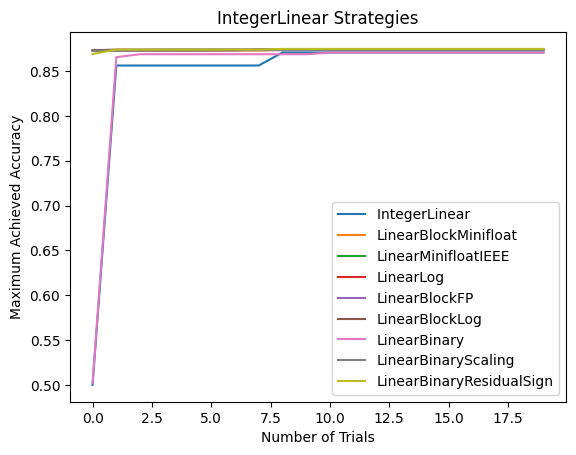

In [24]:
import matplotlib.pyplot as plt

# 横轴：试验次数
x_task1_len= range(len(task1))

# 绘制曲线
plt.plot(x_task1_len, task1, label="IntegerLinear ")
plt.plot(x_task1_len, task3, label="LinearBlockMinifloat")
plt.plot(x_task1_len, task4, label="LinearMinifloatIEEE")
plt.plot(x_task1_len, task5, label="LinearLog")
plt.plot(x_task1_len, task6, label="LinearBlockFP")
plt.plot(x_task1_len, task7, label="LinearBlockLog")
plt.plot(x_task1_len, task8, label="LinearBinary")
plt.plot(x_task1_len, task9, label="LinearBinaryScaling")
plt.plot(x_task1_len, task10, label="LinearBinaryResidualSign")


# 图形设置
plt.xlabel("Number of Trials")
plt.ylabel("Maximum Achieved Accuracy")
plt.title("IntegerLinear Strategies")
plt.legend()
plt.show()

In [13]:
from chop.tools import get_tokenized_dataset
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"
dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)
from transformers import AutoModel

model = AutoModel.from_pretrained(checkpoint)
from chop.tools.utils import deepsetattr
from copy import deepcopy
from transformers import AutoConfig, AutoModelForSequenceClassification

from pathlib import Path
import dill
import torch
with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)
search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        # LinearInteger,
        # LinearMinifloatDenorm,
        # LinearMinifloatIEEE,
        # LinearLog,
        # LinearBlockFP,
        # # LinearBlockMinifloat,
        # LinearBlockLog,
        LinearBinary,
        # LinearBinaryScaling,
        # LinearBinaryResidualSign,
    ],
    'linear_layer_quantization': [8, 16, 32],
    'linear_layer_quantization_fractional':  [2, 4, 8],
    'LinearMinifloatDenorm': [8, 16, 32],
    'LinearMinifloatDenorm_ew': [2, 4, 8],
    'LinearMinifloatDenorm_eb': [2, 4, 8],
    'LinearMinifloatIEEE': [8, 16, 32],
    'LinearMinifloatIEEE_ew': [2, 4, 8],
    'LinearMinifloatIEEE_eb': [2, 4, 8],
    'LinearLog': [8, 16, 32],
    'LinearLog_ew': [2, 4, 8],
    'LinearLog_eb': [2, 4, 8],
    'LinearBlockFP': [8, 16, 32],
    'LinearBlockFP_block_size':[[4], [8], [16]] ,
    'LinearBlockMinifloat_ebw': [2, 4, 8],
    'LinearBlockMinifloat_ew': [2, 4, 8],
    'LinearBlockMinifloat_block_size': [[4], [8], [16]],
    'LinearBlockMinifloat_w': [2, 4, 8],
    'LinearBlockLog': [8, 16, 32],
    'LinearBlockLog_ebw': [2, 4, 8],
    'LinearBlockLog_block_size': [[4], [8], [16]] ,
    'LinearBinary_stochastic': [1, 0],
    'LinearBinary_bipolar': [1, 0],
}

def construct_model(trial):
    # Fetch the model
    my_config = {}
    trial_model = deepcopy(base_model)
    
    # Select quantization and fractional width configurations
    for param in ['linear_layer_quantization', 
                  'linear_layer_quantization_fractional',
                  'LinearMinifloatDenorm',
                  'LinearMinifloatDenorm_ew',
                  'LinearMinifloatDenorm_eb',
                  'LinearMinifloatIEEE',
                  'LinearMinifloatIEEE_ew',
                  'LinearMinifloatIEEE_eb',
                    'LinearLog',
                    'LinearLog_ew',
                    'LinearLog_eb',
                    'LinearBlockFP',
                    'LinearBlockFP_block_size',
                    'LinearBlockMinifloat_ebw',
                    'LinearBlockMinifloat_ew',
                    'LinearBlockMinifloat_block_size',
                    'LinearBlockMinifloat_w',
                    'LinearBlockLog',
                    'LinearBlockLog_ebw',
                    'LinearBlockLog_block_size',
                    'LinearBinary_stochastic',
                    'LinearBinary_bipolar',
                  ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        my_config[param] = search_space[param][chosen_idx]

    # Quantize layers according to Optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            try:
                # Configure parameters for specific layer types
                # if new_layer_cls == LinearInteger:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['linear_layer_quantization'],
                #         "data_in_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "weight_width": my_config['linear_layer_quantization'],
                #         "weight_frac_width": my_config['linear_layer_quantization_fractional'],
                #         "bias_width": my_config['linear_layer_quantization'],
                #         "bias_frac_width": my_config['linear_layer_quantization_fractional'],
                #     }
                # elif new_layer_cls == LinearMinifloatDenorm:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatDenorm'],
                #         "data_in_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "weight_width": my_config['LinearMinifloatDenorm'],
                #         "weight_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #         "bias_width": my_config['LinearMinifloatDenorm'],
                #         "bias_exponent_width": my_config['LinearMinifloatDenorm_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatDenorm_eb'],
                #     }
                # elif new_layer_cls == LinearMinifloatIEEE:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearMinifloatIEEE'],
                #         "data_in_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "data_in_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "weight_width": my_config['LinearMinifloatIEEE'],
                #         "weight_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "weight_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #         "bias_width": my_config['LinearMinifloatIEEE'],
                #         "bias_exponent_width": my_config['LinearMinifloatIEEE_ew'],
                #         "bias_exponent_bias": my_config['LinearMinifloatIEEE_eb'],
                #     }
                # elif new_layer_cls == LinearLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearLog'],
                #         "data_in_exponent_width": my_config['LinearLog_ew'],
                #         "data_in_exponent_bias": my_config['LinearLog_eb'],
                #         "weight_width": my_config['LinearLog'],
                #         "weight_exponent_width": my_config['LinearLog_ew'],
                #         "weight_exponent_bias": my_config['LinearLog_eb'],
                #         "bias_width": my_config['LinearLog'],
                #         "bias_exponent_width": my_config['LinearLog_ew'],
                #         "bias_exponent_bias": my_config['LinearLog_eb'],
                #     }
                # elif new_layer_cls == LinearBlockFP:
                #     kwargs["config"] = {
                #         "weight_width": my_config['LinearBlockFP'],
                #         "weight_exponent_width": my_config['LinearBlockFP'],
                #         "weight_block_size": my_config['LinearBlockFP_block_size'],
                #         "weight_exponent_bias": my_config['LinearBlockFP'],
                #         "data_in_width": my_config['LinearBlockFP'],
                #         "data_in_exponent_width": my_config['LinearBlockFP'],
                #         "data_in_block_size": my_config['LinearBlockFP_block_size'],
                #         "data_in_exponent_bias": my_config['LinearBlockFP'],
                #         "bias_width": my_config['LinearBlockFP'],
                #         "bias_exponent_width": my_config['LinearBlockFP'],
                #         "bias_block_size": my_config['LinearBlockFP_block_size'],
                #         "bias_exponent_bias": my_config['LinearBlockFP'],
                #     }
                # elif new_layer_cls == LinearBlockMinifloat:
                #     kwargs["config"] = {
                #         "weight_exponent_bias_width" : my_config['LinearBlockMinifloat_ebw'],
                #         "weight_exponent_width": my_config['LinearBlockMinifloat_ew'],
                #         "weight_block_size": my_config['LinearBlockMinifloat_block_size'],
                #         "weight_width": my_config['LinearBlockMinifloat_w'],
                #         "data_in_width":my_config["LinearBlockMinifloat_w"],
                #         "data_in_exponent_bias_width":my_config["LinearBlockMinifloat_ew"],
                #         "data_in_exponent_width":my_config["LinearBlockMinifloat_ebw"],
                #         "data_in_block_size":my_config["LinearBlockMinifloat_block_size"],
                #         "bias_width":my_config["LinearBlockMinifloat_w"],
                #         "bias_exponent_width":my_config["LinearBlockMinifloat_ew"],
                #         "bias_exponent_bias_width":my_config["LinearBlockMinifloat_ebw"],
                #         "bias_block_size":my_config["LinearBlockMinifloat_block_size"],
                # #     }
                # elif new_layer_cls == LinearBlockLog:
                #     kwargs["config"] = {
                #         "data_in_width": my_config['LinearBlockLog'],
                #         "data_in_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "data_in_block_size": my_config['LinearBlockLog_block_size'],
                #         "weight_width": my_config['LinearBlockLog'],
                #         "weight_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "weight_block_size": my_config['LinearBlockLog_block_size'],
                #         "bias_width": my_config['LinearBlockLog'],
                #         "bias_exponent_bias_width": my_config['LinearBlockLog_ebw'],
                #         "bias_block_size": my_config['LinearBlockLog_block_size'],
                #     }

                if new_layer_cls == LinearBinary:
                    kwargs["config"] = {
                        'weight_stochastic':my_config['LinearBinary_stochastic'],
                        'weight_bipolar':my_config['LinearBinary_bipolar'],
                    }
                    # print(my_config['LinearBinary_stochastic'])
                    # print(my_config['LinearBinary_bipolar'])

                    
                # elif new_layer_cls == LinearBinaryScaling:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryScaling_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryScaling_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryScaling_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryScaling_bipolar'],
                #         "binary_training": my_config['LinearBinaryScaling_binary_training'],
                #     }
                # elif new_layer_cls == LinearBinaryResidualSign:
                #     kwargs["config"] = {
                #         'weight_stochastic':my_config['LinearBinaryResidualSign_stochastic'],
                #         'weight_bipolar':my_config['LinearBinaryResidualSign_bipolar'],
                #         "data_in_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "data_in_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "bias_stochastic": my_config['LinearBinaryResidualSign_stochastic'],
                #         "bias_bipolar": my_config['LinearBinaryResidualSign_bipolar'],
                #         "binary_training": my_config['LinearBinaryResidualSign_binary_training'],
                #     }
                # Create the new layer (copy the weights if applicable)
                new_layer = new_layer_cls(**kwargs)
                new_layer.weight.data = layer.weight.data.clone()

                # Replace the layer in the model
                deepsetattr(trial_model, name, new_layer)
            except TypeError as e:
                print(f"Error creating layer {name} with class {new_layer_cls}: {e}")
                raise

    return trial_model
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]


from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = TPESampler()

import optuna

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=20,
    timeout=60 * 60 * 24,
)

task8 = [max([t.value for t in study.trials[:i+1]]) for i in range(len(study.trials))]
task8

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
[I 2025-02-10 21:23:13,595] A new study created in memory with name: bert-tiny-nas-study
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/srcPkgs/miniconda3/envs/mase/lib/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearBinary'> which is of type type.
  warnings.warn(message)
/root/local/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
 

Step,Training Loss
500,0.444600
1000,0.318600
1500,0.347100
2000,0.349700
2500,0.330800
3000,0.373800


[I 2025-02-10 21:25:17,495] Trial 0 finished with value: 0.87052 and parameters: {'linear_layer_quantization': 2, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 0, 'LinearMinifloatDenorm_ew': 1, 'LinearMinifloatDenorm_eb': 2, 'LinearMinifloatIEEE': 2, 'LinearMinifloatIEEE_ew': 2, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 2, 'LinearLog_eb': 0, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 1, 'LinearBlockMinifloat_ew': 0, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 2, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearBinary'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encode

Step,Training Loss
500,0.478300
1000,0.321100
1500,0.339400
2000,0.334500
2500,0.323200
3000,0.365000


[I 2025-02-10 21:27:19,388] Trial 1 finished with value: 0.8704 and parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 2, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 0, 'LinearMinifloatIEEE_ew': 0, 'LinearMinifloatIEEE_eb': 2, 'LinearLog': 1, 'LinearLog_ew': 2, 'LinearLog_eb': 2, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 1, 'LinearBlockMinifloat_block_size': 0, 'LinearBlockMinifloat_w': 0, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 0, 'LinearBlockLog_block_size': 1, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearBinary'>, 'bert.encoder

Step,Training Loss
500,0.421700
1000,0.347700


[W 2025-02-10 21:27:50,896] Trial 2 failed with parameters: {'linear_layer_quantization': 1, 'linear_layer_quantization_fractional': 2, 'LinearMinifloatDenorm': 1, 'LinearMinifloatDenorm_ew': 0, 'LinearMinifloatDenorm_eb': 1, 'LinearMinifloatIEEE': 1, 'LinearMinifloatIEEE_ew': 1, 'LinearMinifloatIEEE_eb': 0, 'LinearLog': 2, 'LinearLog_ew': 0, 'LinearLog_eb': 0, 'LinearBlockFP': 1, 'LinearBlockFP_block_size': 0, 'LinearBlockMinifloat_ebw': 0, 'LinearBlockMinifloat_ew': 2, 'LinearBlockMinifloat_block_size': 2, 'LinearBlockMinifloat_w': 2, 'LinearBlockLog': 1, 'LinearBlockLog_ebw': 2, 'LinearBlockLog_block_size': 0, 'LinearBinary_stochastic': 1, 'LinearBinary_bipolar': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearBinary'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearBinary'>, 'bert.encoder.laye

KeyboardInterrupt: 

In [11]:
task8=[0.50224,
 0.86552,
 0.8688,
 0.8688,
 0.8688,
 0.8688,
 0.8688,
 0.8688,
 0.8688,
 0.8688]